# ARIMA FORECASTS

In [1]:
#Import libraries
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import os
import seaborn as sns
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

#### Loading Data

In [2]:
# Read CSVs
PatientConsumption     = pd.read_csv('PatientConsumption 2018-2019.csv').drop_duplicates()
PurchasedOrders        = pd.read_csv('PurchasedOrders 2018-2019.csv').drop_duplicates()
IncompleteOrders       = pd.read_csv('IncompleteOrders 2018-2019.csv').drop_duplicates()
PatentDrugs            = pd.read_csv('Diccionario_v3.csv').drop_duplicates()
PatientConsumption2020 = pd.read_csv('PatientConsumption 2020.csv').drop_duplicates()

# Retrieve date columns and apply to_datetime, set amount columns as numeric
date_columns   = [column for column in PatientConsumption.columns if 'Date' in column]
amount_columns = [column for column in PatientConsumption.keys() if 'Amount' in column]
PatientConsumption[date_columns]   = PatientConsumption[date_columns].apply(pd.to_datetime)
PatientConsumption[amount_columns] = PatientConsumption[amount_columns].astype(int)

date_columns = [column for column in PurchasedOrders.columns if 'Date' in column]
amount_columns = [column for column in PurchasedOrders.keys() if 'Amount' in column]
PurchasedOrders[date_columns]   = PurchasedOrders[date_columns].apply(pd.to_datetime)
PurchasedOrders[amount_columns] = PurchasedOrders[amount_columns].astype(int)

date_columns = [column for column in IncompleteOrders.columns if 'Date' in column]
amount_columns = [column for column in IncompleteOrders.keys() if 'Amount' in column]
IncompleteOrders[date_columns]   = IncompleteOrders[date_columns].apply(pd.to_datetime)
IncompleteOrders[amount_columns] = IncompleteOrders[amount_columns].astype(int)


date_columns   = [column for column in PatientConsumption.columns if 'Date' in column]
amount_columns = [column for column in PatientConsumption.keys() if 'Amount' in column]
# Values to predict
PatientConsumption2020[date_columns]   = PatientConsumption2020[date_columns].apply(pd.to_datetime)
PatientConsumption2020[amount_columns] = PatientConsumption2020[amount_columns].astype(int)

_______________

### This chunk of code comes from the EDA and it contains the 9 patent drugs to forecast. 

In [3]:


# Consumed
MedConsumption = pd.merge(PatientConsumption, PatentDrugs[['MedCode','MedFamily','Compound']], on='MedCode', how='left')
# Requested, Purchased
MedOrders = pd.merge(PurchasedOrders, PatentDrugs[['MedCode','MedFamily','Compound']], on='MedCode', how='left')
MedOrders['YearMonth'] = pd.to_datetime(MedOrders['RequestDate'].dt.year*100+MedOrders['RequestDate'].dt.month, format='%Y%m')
# Incomplete
MedIncompleteOrders = pd.merge(IncompleteOrders[IncompleteOrders['RequestNumber']!=0], PatentDrugs[['MedCode','MedFamily','Compound']], on='MedCode', how='left')
MedIncompleteOrders['YearMonth'] = pd.to_datetime(MedIncompleteOrders['RequestDate'].dt.year*100+MedIncompleteOrders['RequestDate'].dt.month, format='%Y%m')



# 26763 requests
AmountRequested = MedOrders[['YearMonth','RequestNumber','MedCode','AmountRequested']].drop_duplicates()
# 26763 purchases
AmountPurchased = MedOrders.groupby(['YearMonth','RequestNumber','MedCode']).sum()['AmountPurchased'].reset_index()
# 1013 incomplete
AmountReceived = MedIncompleteOrders.groupby(['YearMonth','RequestNumber','MedCode']).sum()['AmountReceived'].reset_index()

# Merge columns to a total of 26763 rows
df = pd.merge(AmountRequested, AmountPurchased, on=['YearMonth','RequestNumber','MedCode'], how='left')
df = pd.merge(df, AmountReceived, on=['YearMonth','RequestNumber','MedCode'], how='left')
# if AmountReceived.isna() : order is complete
df['AmountReceived'] = df.apply(lambda x: x['AmountPurchased'] if pd.isna(x['AmountReceived']) else x['AmountReceived'], axis=1)
# compute shortage amount
df['AmountMissing'] = df['AmountRequested'] - df['AmountReceived']


AmountOrder = df.groupby(['YearMonth','MedCode']).sum().reset_index()


# Consumed
AmountConsumed = MedConsumption.groupby(['ConsumptionDate','MedCode']).sum()['AmountConsumed'].reset_index()
AmountConsumed['YearMonth'] = pd.to_datetime(AmountConsumed['ConsumptionDate'].dt.year*100+AmountConsumed['ConsumptionDate'].dt.month, format='%Y%m')
AmountConsumed = AmountConsumed.loc[:, ['YearMonth','MedCode','AmountConsumed']]


MonthlyCompounds = pd.merge(AmountOrder, AmountConsumed, on=['YearMonth','MedCode'], how='outer')
# fill AmountConsumed.isna() with zeros
#MonthlyCompounds['AmountConsumed'] = MonthlyCompounds['AmountConsumed'].fillna(0)
MonthlyCompounds = MonthlyCompounds.fillna(0)

MonthlyCompounds = pd.merge(MonthlyCompounds, PatentDrugs[['MedCode','MedDescription']], on='MedCode', how='left')



# Values to predict
MedConsumption2020 = pd.merge(PatientConsumption2020, PatentDrugs[['MedCode','MedFamily','Compound']], on='MedCode', how='left')
AmountConsumed2020 = MedConsumption2020.groupby(['ConsumptionDate','MedCode']).sum()['AmountConsumed'].reset_index()
AmountConsumed2020['YearMonth'] = pd.to_datetime(AmountConsumed2020['ConsumptionDate'].dt.year*100+AmountConsumed2020['ConsumptionDate'].dt.month, format='%Y%m')
AmountConsumed2020 = AmountConsumed2020.loc[:, ['YearMonth','MedCode','AmountConsumed']]
AmountConsumed2020 = pd.merge(AmountConsumed2020, PatentDrugs[['MedCode','MedDescription']], on='MedCode', how='left')


<h1><center>Time Series Modeling <br> (ARIMA)</center></h1>

------------

<center><h2> 3302669

In [4]:
code=3302669
df=MonthlyCompounds[MonthlyCompounds["MedCode"]==code][["YearMonth","AmountConsumed"]].reset_index()
df=df.drop("index", axis=1)


test=AmountConsumed2020[AmountConsumed2020["MedCode"]==code]
test=test[["YearMonth", "AmountConsumed"]].reset_index().drop("index", axis=1).set_index("YearMonth")
test

,AmountConsumed
YearMonth,
2020-01-01,245
2020-02-01,125
2020-03-01,190


In [5]:
# Dicky Fuller Test
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.AmountConsumed)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.639151
p-value: 0.085173


Since P-value is greater than the significance level, let’s difference the series and see how the autocorrelation plot looks like.

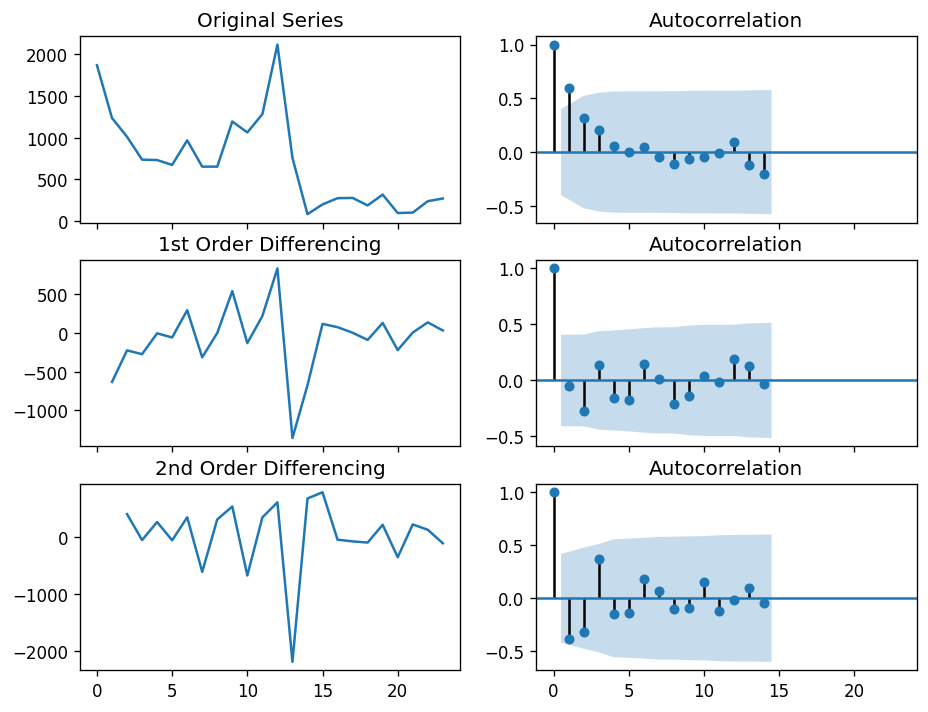

In [6]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Import data

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.AmountConsumed); axes[0, 0].set_title('Original Series')
plot_acf(df.AmountConsumed, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.AmountConsumed.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.AmountConsumed.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.AmountConsumed.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.AmountConsumed.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

<center> Partial Auto Correlation Function (PACF) </center>
$$Yt = \alpha0 + \alpha1 Y{t-1} + \alpha2 Y{t-2} + \alpha3 Y{t-3}$$

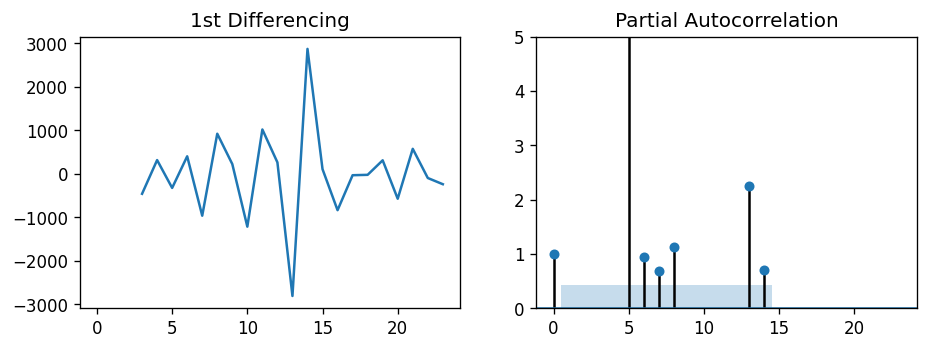

In [7]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.AmountConsumed.diff().diff().diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.AmountConsumed.diff().diff().diff().dropna(), ax=axes[1])

plt.show()

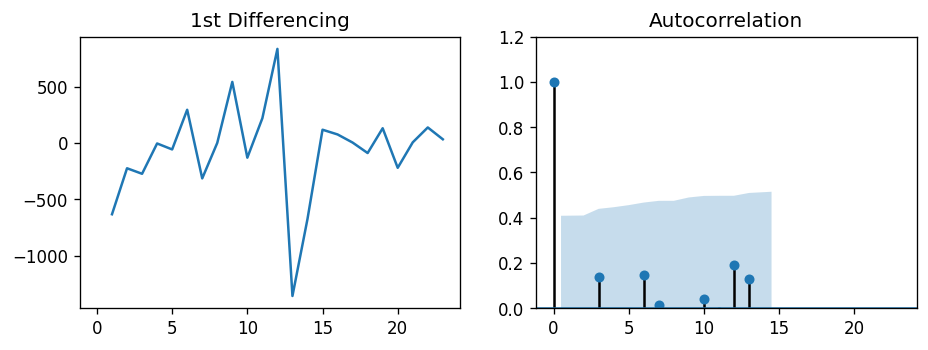

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

# Import data

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.AmountConsumed.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.AmountConsumed.diff().dropna(), ax=axes[1])

plt.show()

In [9]:
#5,2,1 Arima 
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(df.AmountConsumed, order=(5,2,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())


                             ARIMA Model Results                              
Dep. Variable:      D2.AmountConsumed   No. Observations:                   22
Model:                 ARIMA(5, 2, 1)   Log Likelihood                -164.513
Method:                       css-mle   S.D. of innovations            388.287
Date:                Tue, 26 May 2020   AIC                            345.025
Time:                        01:32:35   BIC                            353.754
Sample:                             2   HQIC                           347.082
                                                                              
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       5.4470     10.051      0.542      0.588     -14.253      25.147
ar.L1.D2.AmountConsumed    -0.0080      0.236     -0.034      0.973      -0.470       0.454


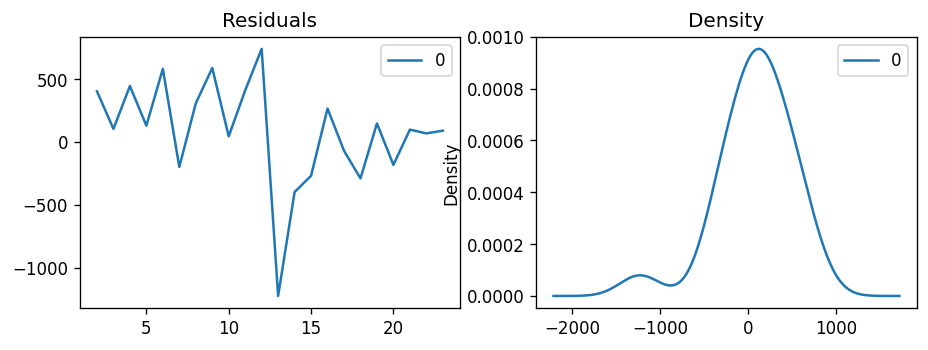

In [10]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

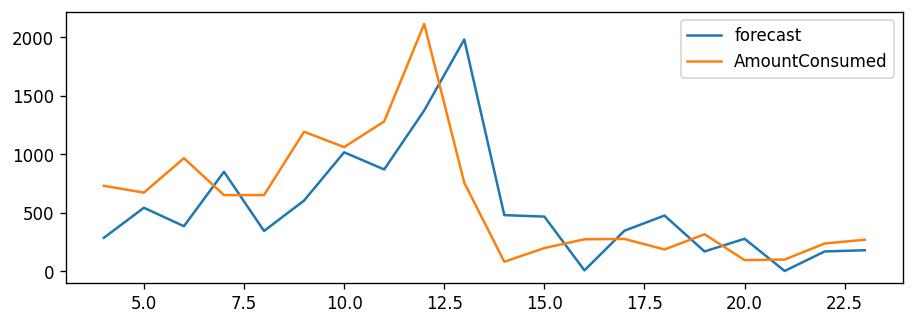

In [11]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

In [12]:
df=df.set_index("YearMonth")
from statsmodels.tsa.stattools import acf

# Create Training and Test

train = df


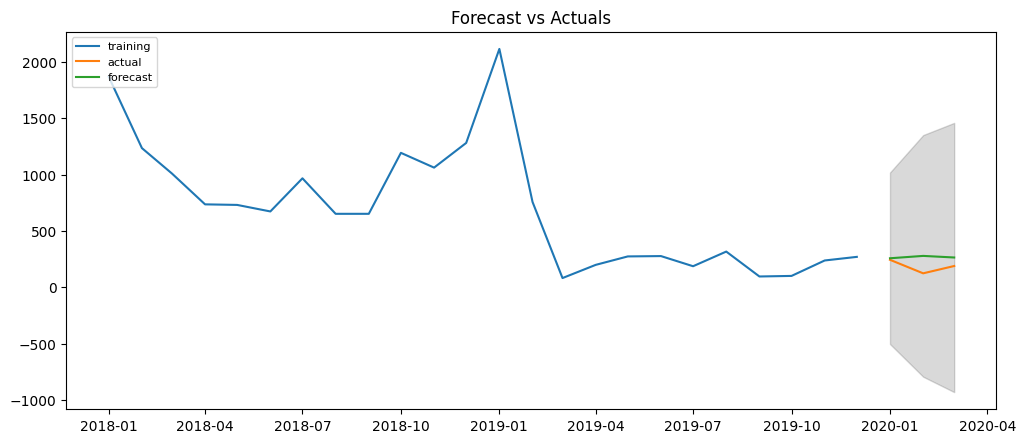

In [13]:
# Build Model

model = ARIMA(train, order=(5, 2, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(3, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [14]:
#Correlation
np.corrcoef(fc, test.values.reshape(3,))

array([[ 1.        , -0.98929481],
       [-0.98929481,  1.        ]])

In [15]:
#MAPE
mape=np.mean(np.abs(fc - test.values.reshape(3,))/np.abs(test.values.reshape(3,)))
mape

0.5632855651060946

In [16]:
#MAE
mae=np.mean(np.abs(fc - test.values.reshape(3,)))
mae

81.2449277386011

In [17]:
forecast=pd.DataFrame(fc.reshape(3,1))
forecast=forecast.rename(columns={0:"Forecast"})
forecast["YearMonth"]=(["2020-01-01", "2020-02-01", "2020-03-01"])
forecast=forecast.set_index("YearMonth")
forecast

,Forecast
YearMonth,
2020-01-01,258.609060
2020-02-01,279.602084
2020-03-01,265.523639


In [18]:
x=pd.merge(test, forecast, left_index=True, right_index=True)
bd=train.append(x)
bd["MedCode"]=code
bd.to_csv("3302669_forecast.csv")

In [19]:
d = {'MAPE': [mape], 'MAE': [mae], "AIC":[fitted.aic], "MedCode":[code]}
metrics = pd.DataFrame(data=d)
metrics

,MAPE,MAE,AIC,MedCode
0,0.563286,81.244928,345.025417,3302669



<center><h2> 3302934


In [20]:
code=3302934

df=MonthlyCompounds[MonthlyCompounds["MedCode"]==code][["YearMonth","AmountConsumed"]].reset_index()
df=df.sort_values("YearMonth")
df=df.drop("index", axis=1).reset_index().drop("index", axis=1)


test=AmountConsumed2020[AmountConsumed2020["MedCode"]==code]
test=test[["YearMonth", "AmountConsumed"]].reset_index().drop("index", axis=1).set_index("YearMonth")
test
df.head()

,YearMonth,AmountConsumed
0,2018-01-01,6.0
1,2018-02-01,7.0
2,2018-03-01,8.0
3,2018-04-01,4.0
4,2018-05-01,6.0


In [21]:
# Dicky Fuller Test
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.AmountConsumed)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.803084
p-value: 0.378931


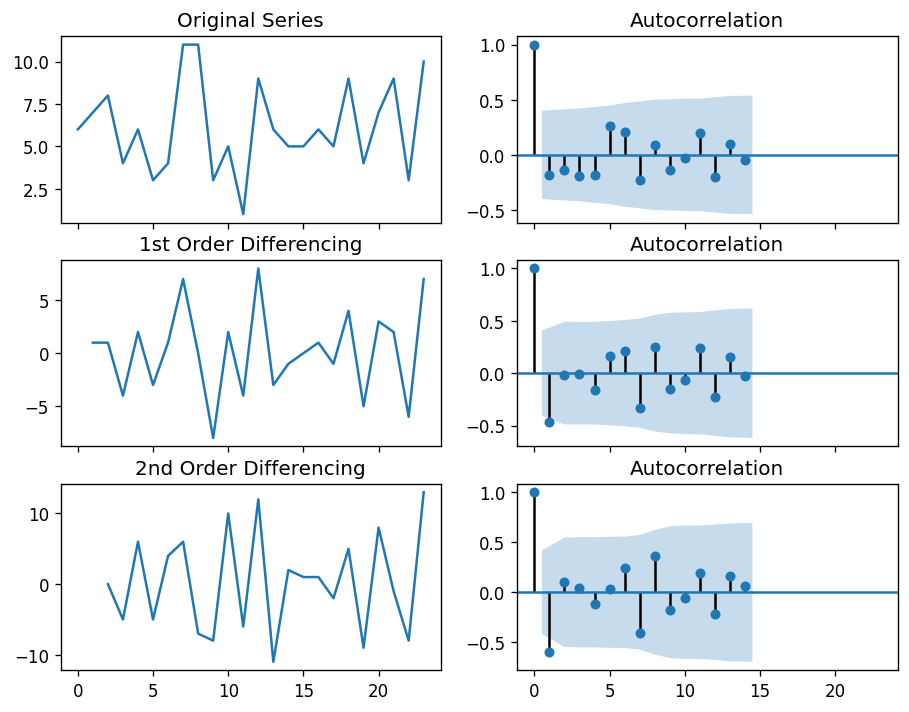

In [22]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Import data

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.AmountConsumed); axes[0, 0].set_title('Original Series')
plot_acf(df.AmountConsumed, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.AmountConsumed.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.AmountConsumed.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.AmountConsumed.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.AmountConsumed.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

<center> Partial Auto Correlation Function (PACF) </center>
$$Yt = \alpha0 + \alpha1 Y{t-1} + \alpha2 Y{t-2} + \alpha3 Y{t-3}$$

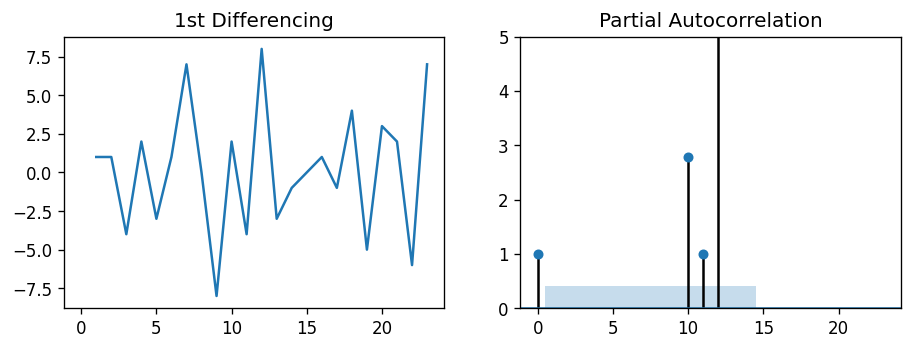

In [23]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.AmountConsumed.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.AmountConsumed.diff().dropna(), ax=axes[1])

plt.show()

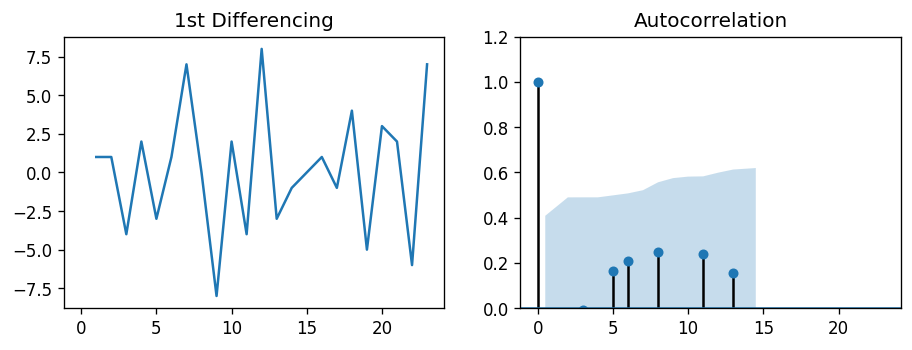

In [24]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

# Import data

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.AmountConsumed.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.AmountConsumed.diff().dropna(), ax=axes[1])

plt.show()

In [25]:
#Arima Estimation
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(df.AmountConsumed, order=(4,2,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())


                             ARIMA Model Results                              
Dep. Variable:      D2.AmountConsumed   No. Observations:                   22
Model:                 ARIMA(4, 2, 1)   Log Likelihood                 -57.408
Method:                       css-mle   S.D. of innovations              2.789
Date:                Tue, 26 May 2020   AIC                            128.816
Time:                        01:32:39   BIC                            136.453
Sample:                             2   HQIC                           130.615
                                                                              
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0188      0.031      0.601      0.548      -0.043       0.080
ar.L1.D2.AmountConsumed    -0.8511      0.184     -4.635      0.000      -1.211      -0.491


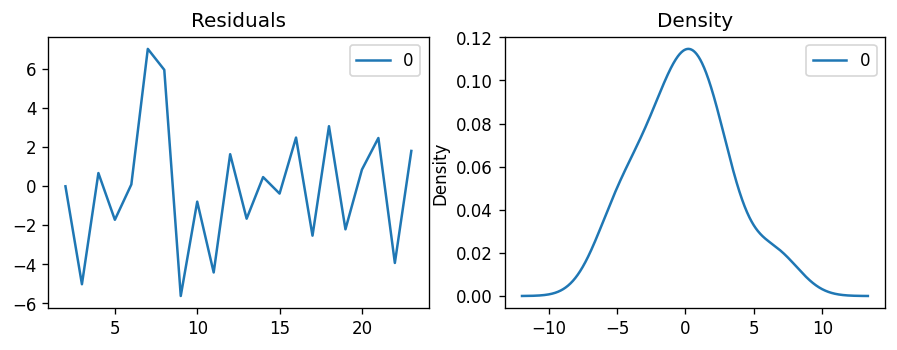

In [26]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

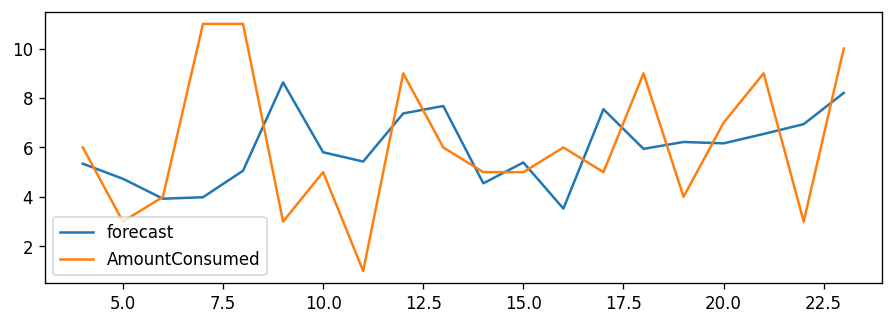

In [27]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

In [28]:
df=df.set_index("YearMonth")
# Create Training and Test
train = df


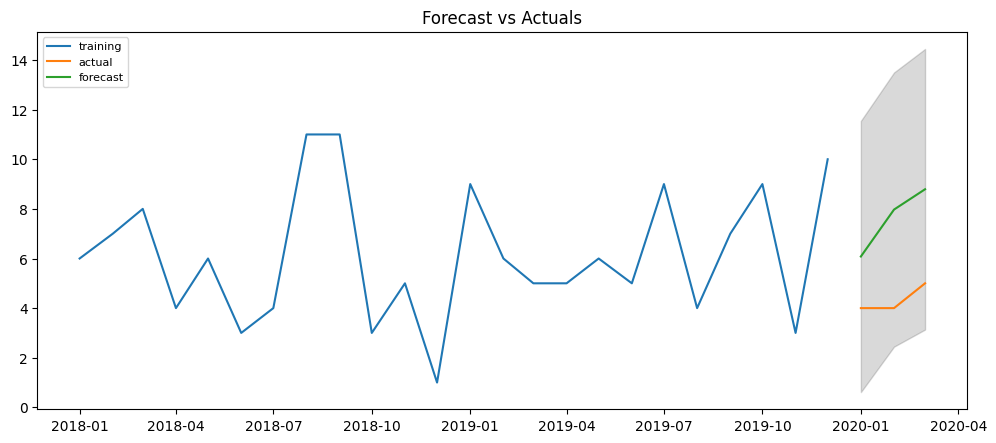

In [29]:
# Build Model

model = ARIMA(train, order=(4, 2, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(3, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [30]:
#Correlation
np.corrcoef(fc, test.values.reshape(3,))

array([[1.        , 0.73277273],
       [0.73277273, 1.        ]])

In [31]:
#MAPE
mape=np.mean(np.abs(fc - test.values.reshape(3,))/np.abs(test.values.reshape(3,)))
mape

0.7571624343831763

In [32]:
#MAE
mae=np.mean(np.abs(fc - test.values.reshape(3,)))
mae

3.2814023088667867

In [33]:
forecast=pd.DataFrame(fc.reshape(3,1))
forecast=forecast.rename(columns={0:"Forecast"})
forecast["YearMonth"]=(["2020-01-01", "2020-02-01", "2020-03-01"])
forecast=forecast.set_index("YearMonth")
forecast

,Forecast
YearMonth,
2020-01-01,6.080257
2020-02-01,7.972661
2020-03-01,8.791289


In [34]:
x=pd.merge(test, forecast, left_index=True, right_index=True)
bd=train.append(x)
bd["MedCode"]=code
bd.to_csv("3302934_forecast.csv")

In [35]:
d = {'MAPE': [mape], 'MAE': [mae], "AIC":[fitted.aic], "MedCode":[code]}
metrics = pd.DataFrame(data=d)
metrics

,MAPE,MAE,AIC,MedCode
0,0.757162,3.281402,128.815578,3302934



<center><h2> 3302307


In [36]:
code=3302307

df=MonthlyCompounds[MonthlyCompounds["MedCode"]==code][["YearMonth","AmountConsumed"]].reset_index()
df=df.sort_values("YearMonth")
df=df.drop("index", axis=1).reset_index().drop("index", axis=1)


test=AmountConsumed2020[AmountConsumed2020["MedCode"]==code]
test=test[["YearMonth", "AmountConsumed"]].reset_index().drop("index", axis=1).set_index("YearMonth")


In [37]:
# Dicky Fuller Test
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.AmountConsumed)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4.993642
p-value: 0.000023


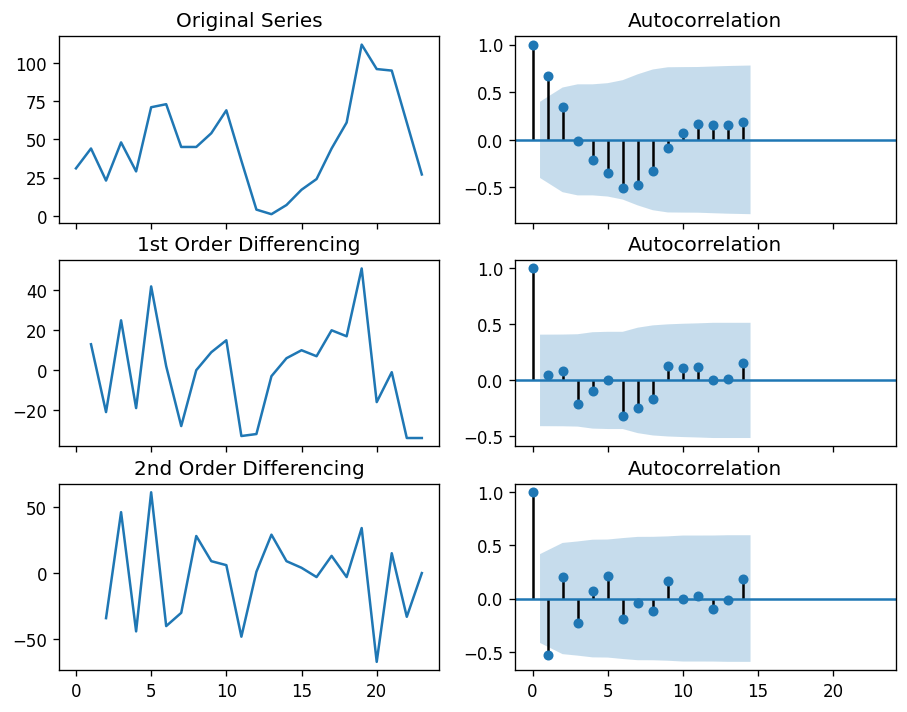

In [38]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Import data

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.AmountConsumed); axes[0, 0].set_title('Original Series')
plot_acf(df.AmountConsumed, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.AmountConsumed.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.AmountConsumed.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.AmountConsumed.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.AmountConsumed.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

<center> Partial Auto Correlation Function (PACF) </center>
$$Yt = \alpha0 + \alpha1 Y{t-1} + \alpha2 Y{t-2} + \alpha3 Y{t-3}$$

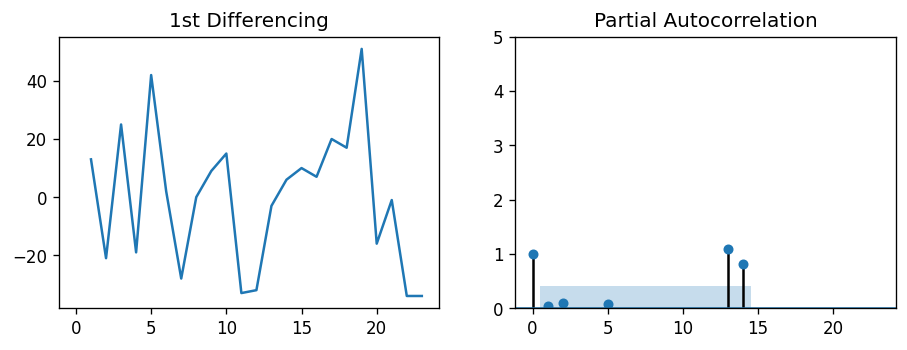

In [39]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.AmountConsumed.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.AmountConsumed.diff().dropna(), ax=axes[1])

plt.show()

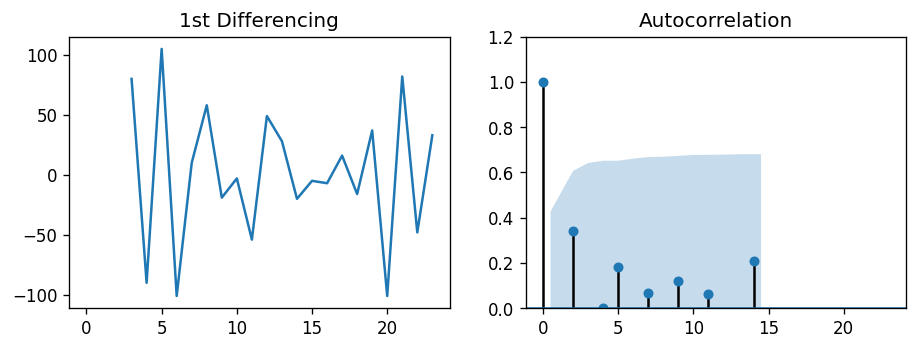

In [40]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

# Import data

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.AmountConsumed.diff().diff().diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.AmountConsumed.diff().diff().diff().dropna(), ax=axes[1])

plt.show()

In [41]:
#ARIMA
model = ARIMA(df.AmountConsumed, order=(6,0,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())


                              ARMA Model Results                              
Dep. Variable:         AmountConsumed   No. Observations:                   24
Model:                     ARMA(6, 0)   Log Likelihood                -114.846
Method:                       css-mle   S.D. of innovations            447.849
Date:                Tue, 26 May 2020   AIC                            245.692
Time:                        01:32:43   BIC                            255.116
Sample:                             0   HQIC                           248.192
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   41.7720        nan        nan        nan         nan         nan
ar.L1.AmountConsumed     0.6858   3.54e-06   1.94e+05      0.000       0.686       0.686
ar.L2.Amount

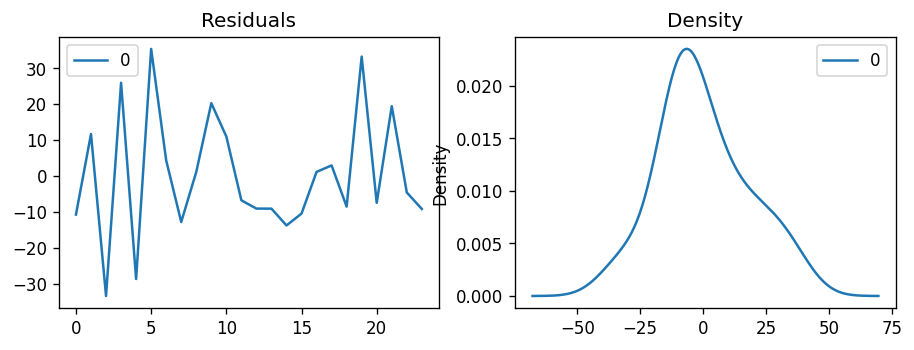

In [42]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

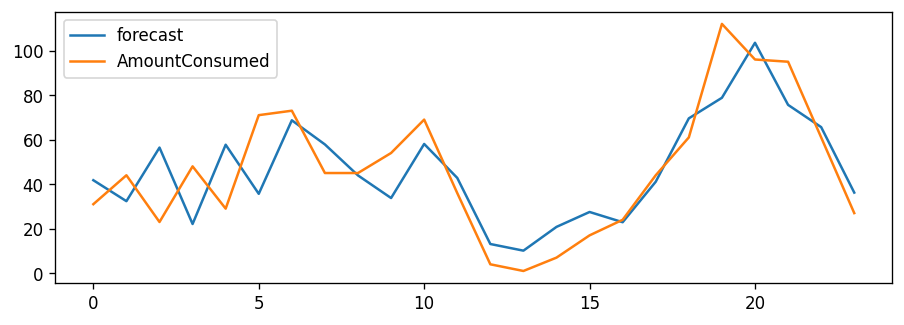

In [43]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

In [44]:
# Create Training and Test
df=df.set_index("YearMonth")
train = df

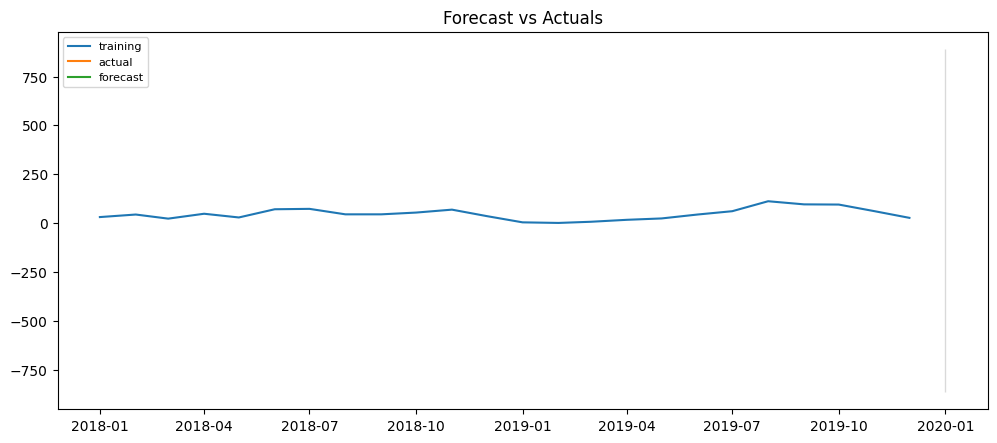

In [45]:
# Build Model

model = ARIMA(train, order=(6, 0, 0))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(len(test), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

This MedCode only has January 2020 to forecast, thus we do not see the lines in the plot, but we do have a forecast. 

In [46]:
#MAPE
mape=np.mean(np.abs(fc - test.values.reshape(len(test),))/np.abs(test.values.reshape(len(test),)))
mape

1.6637858785136543

In [47]:
#MAE
mae=np.mean(np.abs(fc - test.values.reshape(len(test),)))
mae

8.318929392568272

In [48]:
forecast=pd.DataFrame(fc.reshape(len(test),1))
forecast=forecast.rename(columns={0:"Forecast"})
forecast["YearMonth"]=(["2020-01-01"])
forecast=forecast.set_index("YearMonth")
forecast

,Forecast
YearMonth,
2020-01-01,13.318929


In [49]:
x=pd.merge(test, forecast, left_index=True, right_index=True)
bd=train.append(x)
bd["MedCode"]=code
bd.to_csv("3302307 _forecast.csv")

In [50]:
d = {'MAPE': [mape], 'MAE': [mae], "AIC":[fitted.aic], "MedCode":[code]}
metrics = pd.DataFrame(data=d)
metrics

,MAPE,MAE,AIC,MedCode
0,1.663786,8.318929,245.691971,3302307



<center><h2> 3301778


In [51]:
code=3301778

df=MonthlyCompounds[MonthlyCompounds["MedCode"]==code][["YearMonth","AmountConsumed"]].reset_index()
df=df.sort_values("YearMonth")
df=df.drop("index", axis=1).reset_index().drop("index", axis=1)


test=AmountConsumed2020[AmountConsumed2020["MedCode"]==code]
test=test[["YearMonth", "AmountConsumed"]].reset_index().drop("index", axis=1).set_index("YearMonth")
test


,AmountConsumed
YearMonth,
2020-01-01,22
2020-02-01,6
2020-03-01,3


In [52]:
# Dicky Fuller Test
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.AmountConsumed)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4.294214
p-value: 0.000455


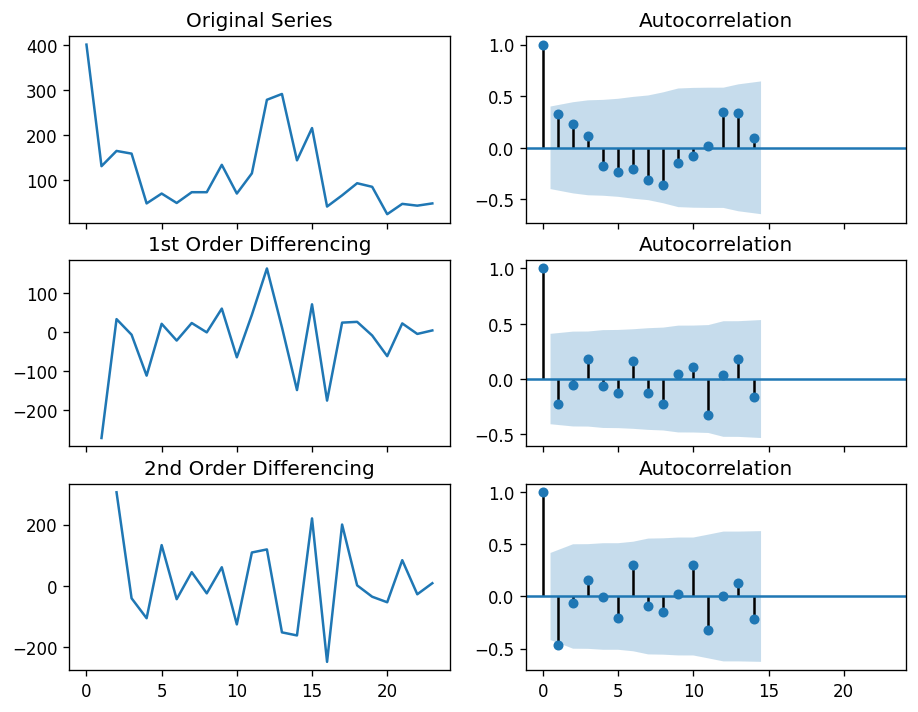

In [53]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Import data

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.AmountConsumed); axes[0, 0].set_title('Original Series')
plot_acf(df.AmountConsumed, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.AmountConsumed.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.AmountConsumed.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.AmountConsumed.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.AmountConsumed.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

<center> Partial Auto Correlation Function (PACF) </center>
$$Yt = \alpha0 + \alpha1 Y{t-1} + \alpha2 Y{t-2} + \alpha3 Y{t-3}$$

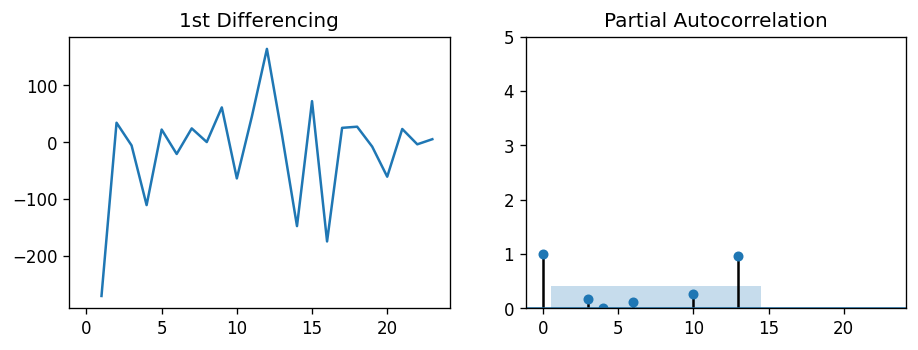

In [54]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.AmountConsumed.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.AmountConsumed.diff().dropna(), ax=axes[1])

plt.show()

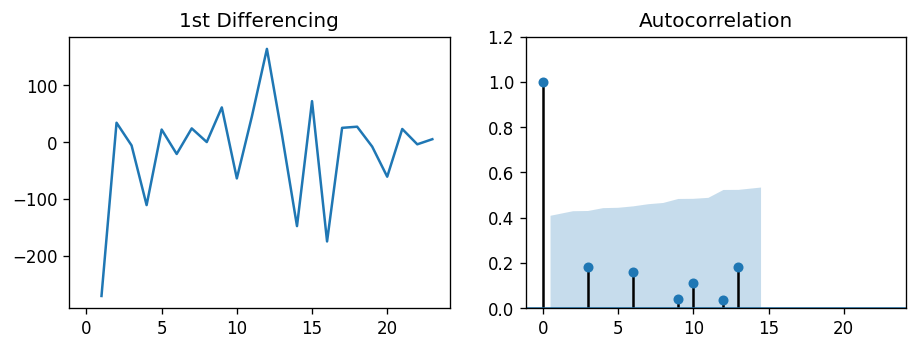

In [55]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

# Import data

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.AmountConsumed.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.AmountConsumed.diff().dropna(), ax=axes[1])

plt.show()

In [56]:
#ARIMA

model = ARIMA(df.AmountConsumed, order=(2,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())


                             ARIMA Model Results                              
Dep. Variable:       D.AmountConsumed   No. Observations:                   23
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -134.806
Method:                       css-mle   S.D. of innovations             84.642
Date:                Tue, 26 May 2020   AIC                            277.612
Time:                        01:32:47   BIC                            282.154
Sample:                             1   HQIC                           278.754
                                                                              
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    -11.8914     11.698     -1.017      0.309     -34.819      11.036
ar.L1.D.AmountConsumed    -0.3836      0.252     -1.522      0.128      -0.878       0.110
ar.L

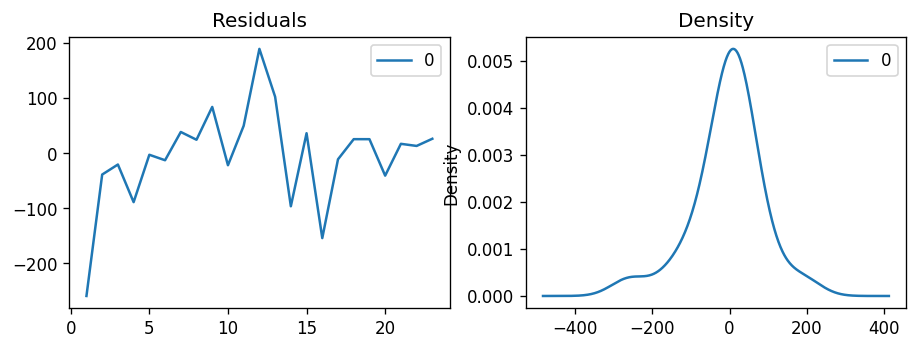

In [57]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

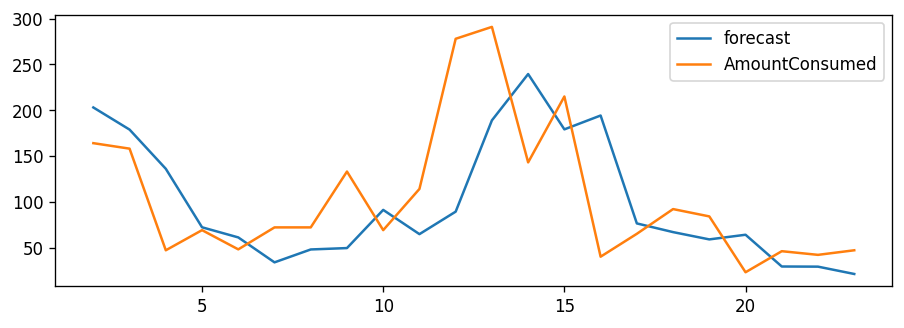

In [58]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

In [59]:
# Create Training and Test
df=df.set_index("YearMonth")
train = df

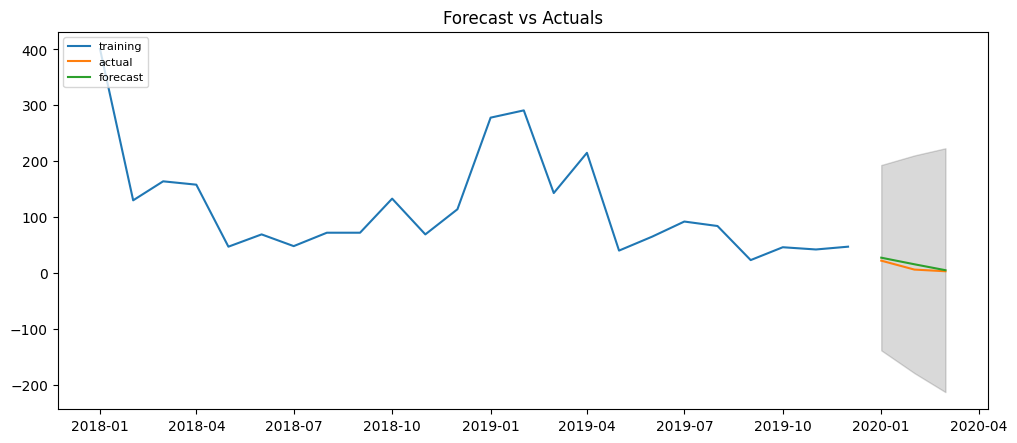

In [60]:
# Build Model

model = ARIMA(train, order=(2, 1, 0))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(len(test), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [61]:
#Correlation
np.corrcoef(fc, test.values.reshape(len(test),))

array([[1.        , 0.94080821],
       [0.94080821, 1.        ]])

In [62]:
#MAPE
mape=np.mean(np.abs(fc - test.values.reshape(len(test),))/np.abs(test.values.reshape(len(test),)))
mape

0.8197434216536772

In [63]:
#MAE
mae=np.mean(np.abs(fc - test.values.reshape(len(test),)))
mae

5.562886428850965

In [64]:
forecast=pd.DataFrame(fc.reshape(len(test),1))
forecast=forecast.rename(columns={0:"Forecast"})
forecast["YearMonth"]=(["2020-01-01", "2020-02-01", "2020-03-01"])
forecast=forecast.set_index("YearMonth")
forecast

,Forecast
YearMonth,
2020-01-01,27.279326
2020-02-01,15.503102
2020-03-01,4.906232


In [65]:
x=pd.merge(test, forecast, left_index=True, right_index=True)
bd=train.append(x)
bd["MedCode"]=code
bd.to_csv("3301778_forecast.csv")

In [66]:
d = {'MAPE': [mape], 'MAE': [mae], "AIC":[fitted.aic], "MedCode":[code]}
metrics = pd.DataFrame(data=d)
metrics

,MAPE,MAE,AIC,MedCode
0,0.819743,5.562886,277.611764,3301778


<center><h2> 3300115

In [67]:
code=3300115

df=MonthlyCompounds[MonthlyCompounds["MedCode"]==code][["YearMonth","AmountConsumed"]].reset_index()
df=df.sort_values("YearMonth")
df=df.drop("index", axis=1).reset_index().drop("index", axis=1)


test=AmountConsumed2020[AmountConsumed2020["MedCode"]==code]
test=test[["YearMonth", "AmountConsumed"]].reset_index().drop("index", axis=1).set_index("YearMonth")

In [68]:
# Dicky Fuller Test
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.AmountConsumed)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -5.749217
p-value: 0.000001


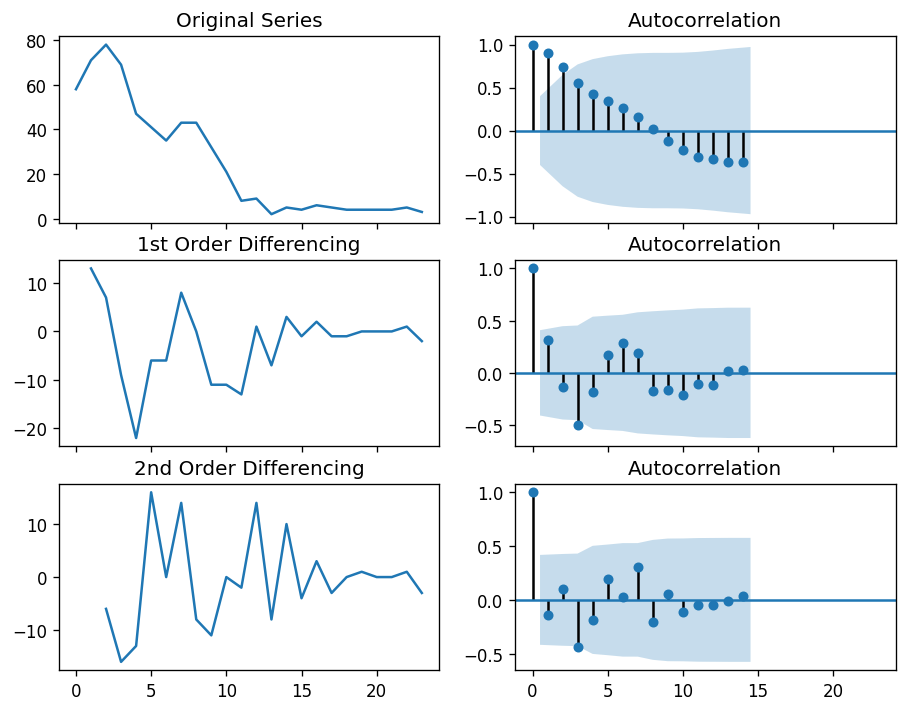

In [69]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Import data

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.AmountConsumed); axes[0, 0].set_title('Original Series')
plot_acf(df.AmountConsumed, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.AmountConsumed.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.AmountConsumed.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.AmountConsumed.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.AmountConsumed.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

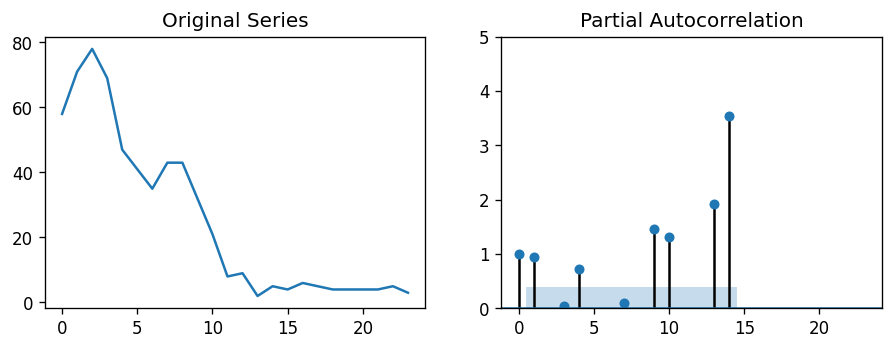

In [70]:
# PACF plot 
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.AmountConsumed); axes[0].set_title('Original Series')
axes[1].set(ylim=(0,5))
plot_pacf(df.AmountConsumed.dropna(), ax=axes[1])

plt.show()

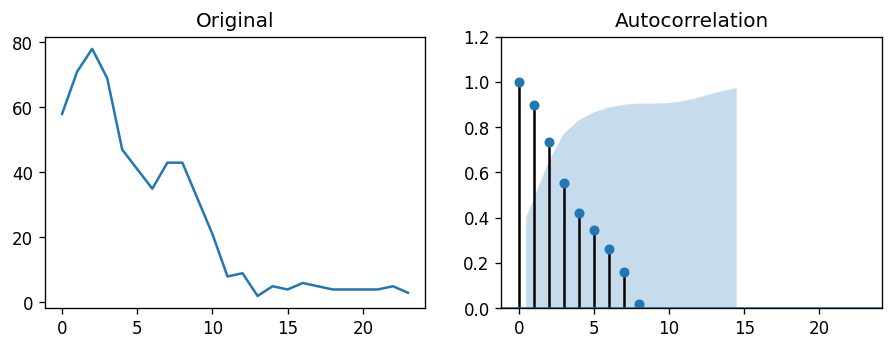

In [71]:
#ACF
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.AmountConsumed); axes[0].set_title('Original')
axes[1].set(ylim=(0,1.2))
plot_acf(df.AmountConsumed.dropna(), ax=axes[1])

plt.show()

In [72]:

#ARIMA

model = ARIMA(df.AmountConsumed, order=(3,0,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())


                              ARMA Model Results                              
Dep. Variable:         AmountConsumed   No. Observations:                   24
Model:                     ARMA(3, 0)   Log Likelihood                 -81.280
Method:                       css-mle   S.D. of innovations              6.741
Date:                Tue, 26 May 2020   AIC                            172.560
Time:                        01:32:50   BIC                            178.450
Sample:                             0   HQIC                           174.123
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   24.3185     14.765      1.647      0.100      -4.619      53.256
ar.L1.AmountConsumed     1.4628      0.203      7.212      0.000       1.065       1.860
ar.L2.Amount

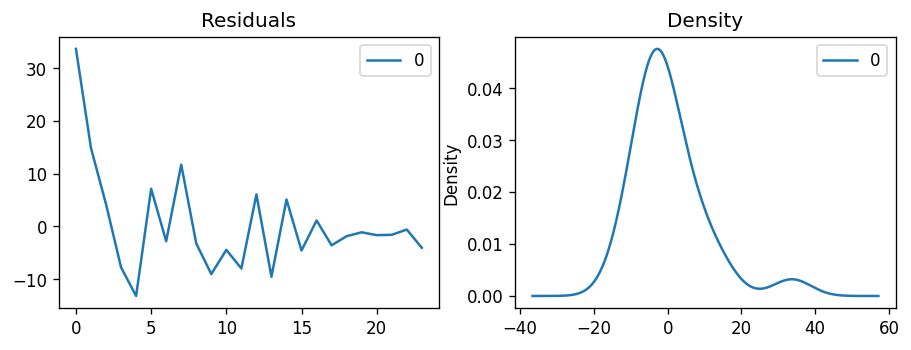

In [73]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

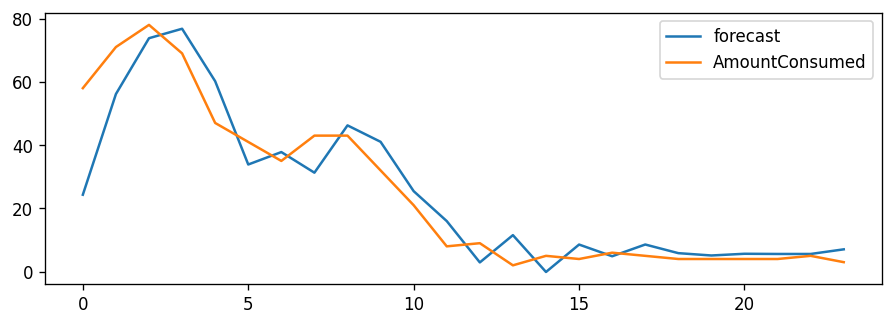

In [74]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

In [75]:
# Create Training and Test
df=df.set_index("YearMonth")
train = df

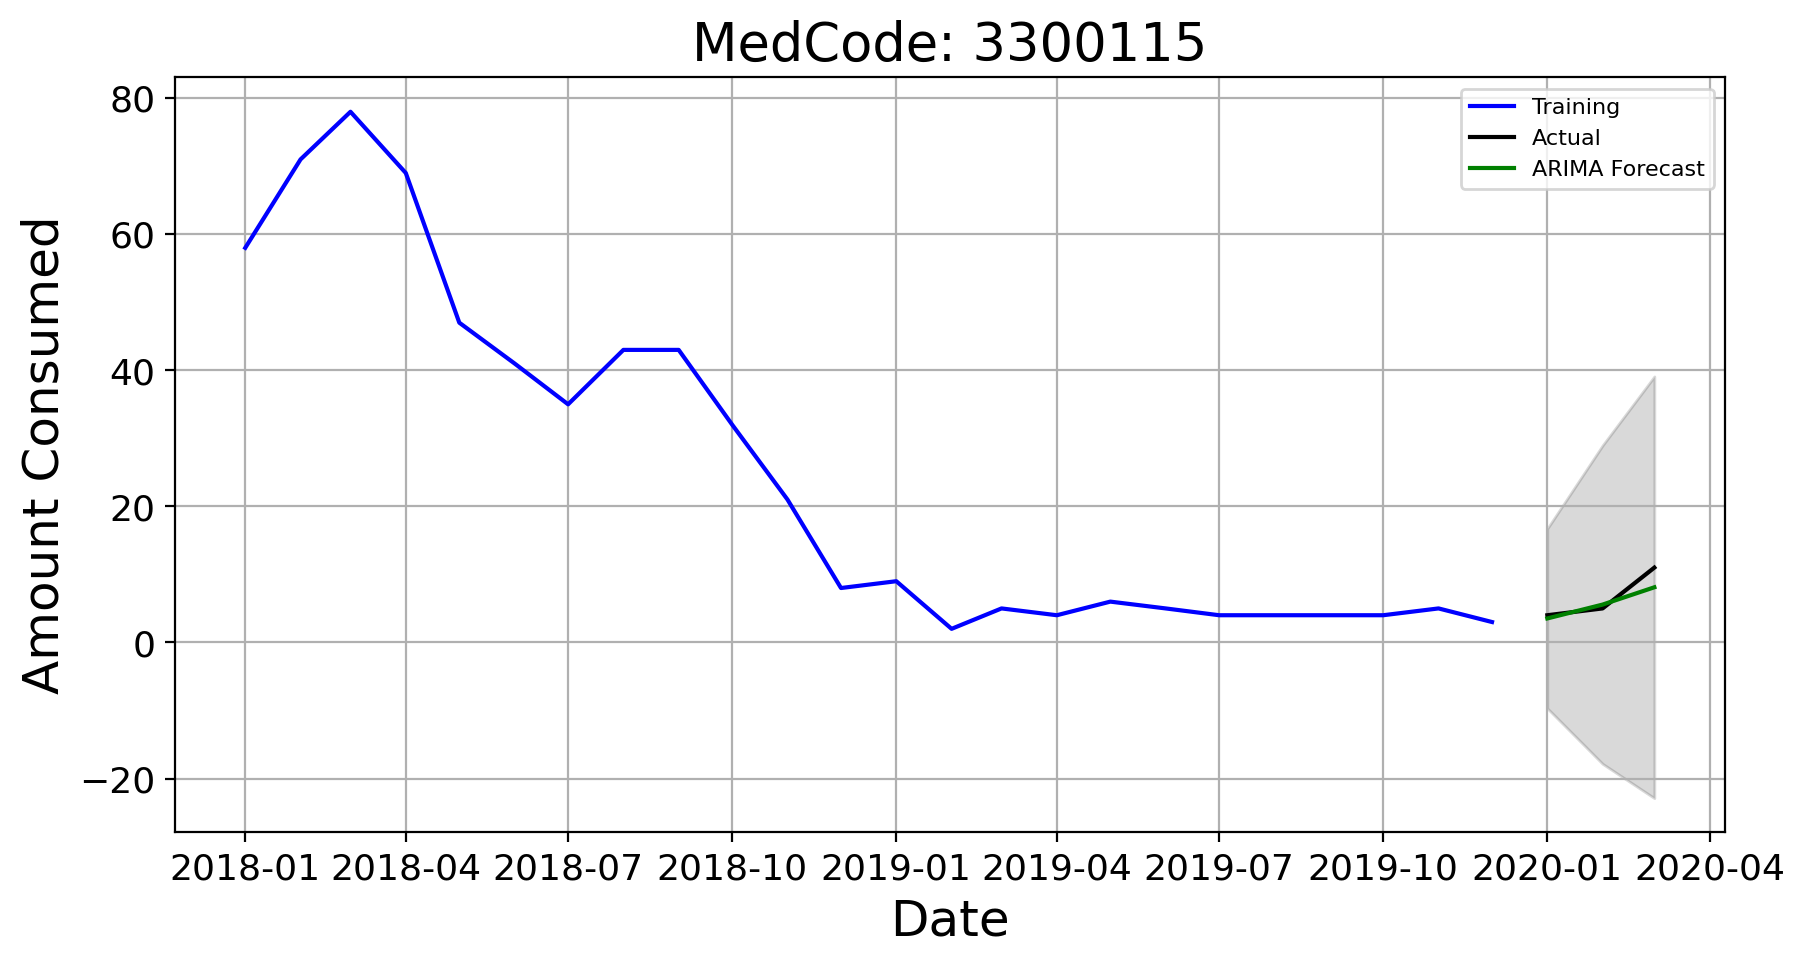

In [76]:
# Build Model

model = ARIMA(train, order=(3, 0, 0))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(len(test), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(10,5), dpi=200)
plt.plot(train, label='Training', color="b")
plt.plot(test, label='Actual', color="black")
plt.plot(fc_series, label='ARIMA Forecast', color="green")
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('MedCode: 3300115', fontsize= 19)
plt.legend(loc='upper right', fontsize=8)
plt.xlabel('Date', size=18)
plt.ylabel('Amount Consumed', size=18)
plt.xticks(size=13)
plt.yticks(size=13)
plt.grid(True)


plt.savefig("Indaflex.png", dpi=200, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

plt.show()

In [77]:
#Correlation
np.corrcoef(fc, test.values.reshape(len(test),))

array([[1.        , 0.94672294],
       [0.94672294, 1.        ]])

In [78]:
#MAPE
mape=np.mean(np.abs(fc - test.values.reshape(len(test),))/np.abs(test.values.reshape(len(test),)))
mape

0.16477993016505882

In [79]:
#MAE
mae=np.mean(np.abs(fc - test.values.reshape(len(test),)))
mae

1.3104251047594022

In [80]:
forecast=pd.DataFrame(fc.reshape(len(test),1))
forecast=forecast.rename(columns={0:"Forecast"})
forecast["YearMonth"]=(["2020-01-01", "2020-02-01", "2020-03-01"])
forecast=forecast.set_index("YearMonth")
forecast

,Forecast
YearMonth,
2020-01-01,3.527478
2020-02-01,5.566291
2020-03-01,8.107537


In [81]:
x=pd.merge(test, forecast, left_index=True, right_index=True)
bd=train.append(x)
bd["MedCode"]=code
bd.to_csv("3300115_forecast.csv")

In [82]:
d = {'MAPE': [mape], 'MAE': [mae], "AIC":[fitted.aic], "MedCode":[code]}
metrics = pd.DataFrame(data=d)
metrics

,MAPE,MAE,AIC,MedCode
0,0.16478,1.310425,172.559887,3300115


<center><h2> 3300142

In [83]:
code=3300142

df=MonthlyCompounds[MonthlyCompounds["MedCode"]==code][["YearMonth","AmountConsumed"]].reset_index()
df=df.sort_values("YearMonth")
df=df.drop("index", axis=1).reset_index().drop("index", axis=1)


test=AmountConsumed2020[AmountConsumed2020["MedCode"]==code]
test=test[["YearMonth", "AmountConsumed"]].reset_index().drop("index", axis=1).set_index("YearMonth")
test


,AmountConsumed
YearMonth,
2020-01-01,4
2020-02-01,5
2020-03-01,2


In [84]:
# Dicky Fuller Test
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.AmountConsumed)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.794523
p-value: 0.383184


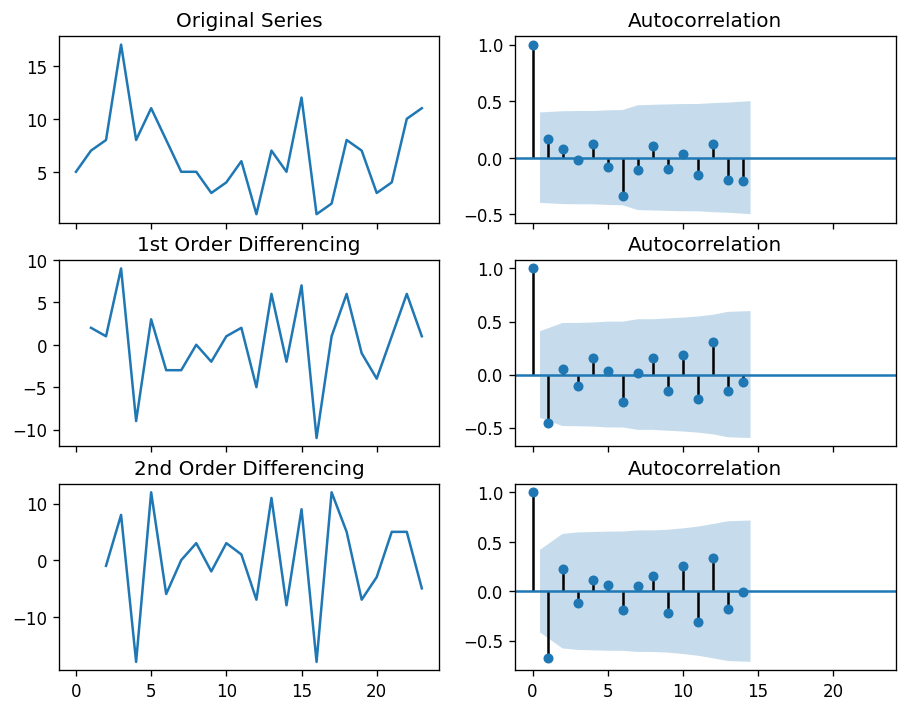

In [85]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Import data

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.AmountConsumed); axes[0, 0].set_title('Original Series')
plot_acf(df.AmountConsumed, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.AmountConsumed.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.AmountConsumed.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.AmountConsumed.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.AmountConsumed.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

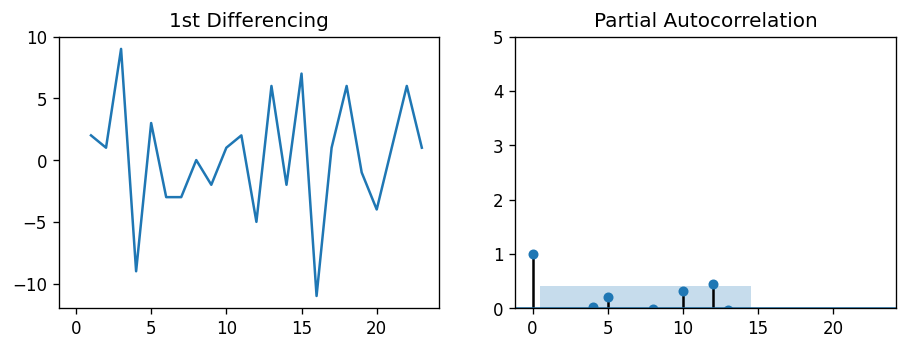

In [86]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.AmountConsumed.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.AmountConsumed.diff().dropna(), ax=axes[1])

plt.show()

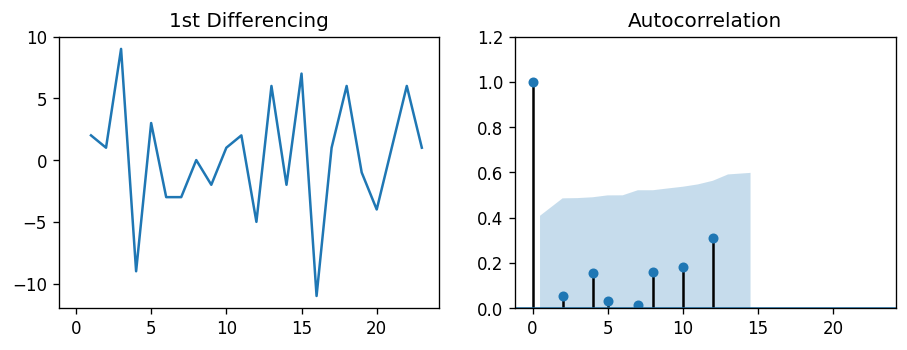

In [87]:
#ACF
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.AmountConsumed.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.AmountConsumed.diff().dropna(), ax=axes[1])

plt.show()

In [88]:
#ARIMA
model = ARIMA(df.AmountConsumed, order=(2,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:       D.AmountConsumed   No. Observations:                   23
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 -63.721
Method:                       css-mle   S.D. of innovations              3.552
Date:                Tue, 26 May 2020   AIC                            139.441
Time:                        01:32:54   BIC                            146.254
Sample:                             1   HQIC                           141.155
                                                                              
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.0752      0.133     -0.564      0.573      -0.336       0.186
ar.L1.D.AmountConsumed    -0.7569        nan        nan        nan         nan         nan
ar.L

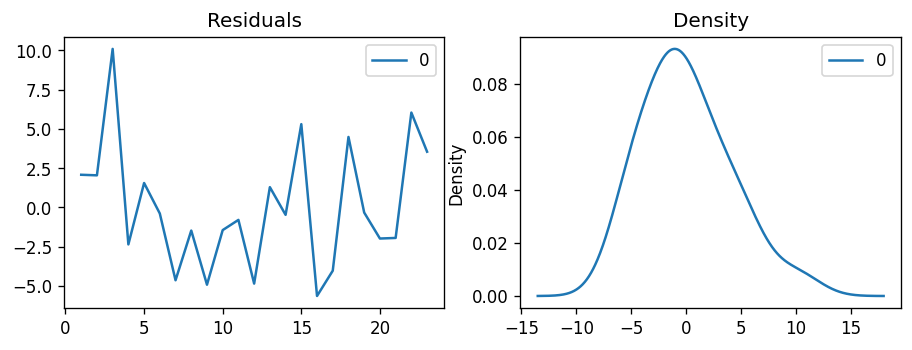

In [89]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

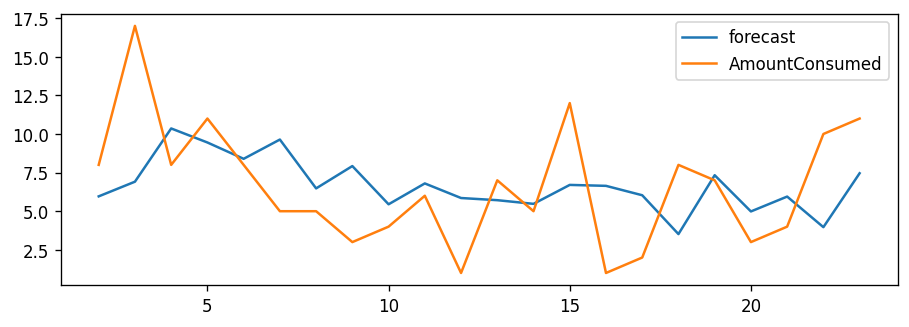

In [90]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

In [91]:
# Create Training and Test
df=df.set_index("YearMonth")
train = df

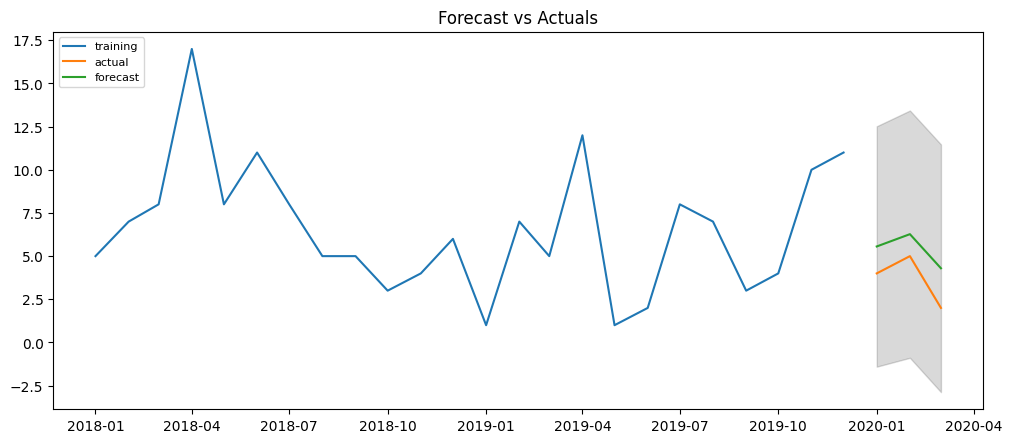

In [92]:
# Build Model

model = ARIMA(train, order=(2, 1, 2))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(len(test), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [93]:
#Correlation
np.corrcoef(fc, test.values.reshape(len(test),))

array([[1.        , 0.99952895],
       [0.99952895, 1.        ]])

In [94]:
#MAPE
mape=np.mean(np.abs(fc - test.values.reshape(len(test),))/np.abs(test.values.reshape(len(test),)))
mape

0.5975980457868296

In [95]:
#MAE
mae=np.mean(np.abs(fc - test.values.reshape(len(test),)))
mae

1.7096189149574583

In [96]:
forecast=pd.DataFrame(fc.reshape(len(test),1))
forecast=forecast.rename(columns={0:"Forecast"})
forecast["YearMonth"]=(["2020-01-01", "2020-02-01", "2020-03-01"])
forecast=forecast.set_index("YearMonth")
forecast

,Forecast
YearMonth,
2020-01-01,5.559689
2020-02-01,6.272373
2020-03-01,4.296794


In [97]:
x=pd.merge(test, forecast, left_index=True, right_index=True)
bd=train.append(x)
bd["MedCode"]=code
bd.to_csv("3300142_forecast.csv")

In [98]:
d = {'MAPE': [mape], 'MAE': [mae], "AIC":[fitted.aic], "MedCode":[code]}
metrics = pd.DataFrame(data=d)
metrics

,MAPE,MAE,AIC,MedCode
0,0.597598,1.709619,139.441455,3300142


<center><h2> 3500322

In [99]:
code=3500322

df=MonthlyCompounds[MonthlyCompounds["MedCode"]==code][["YearMonth","AmountConsumed"]].reset_index()
df=df.sort_values("YearMonth")
df=df.drop("index", axis=1).reset_index().drop("index", axis=1)


test=AmountConsumed2020[AmountConsumed2020["MedCode"]==code]
test=test[["YearMonth", "AmountConsumed"]].reset_index().drop("index", axis=1).set_index("YearMonth")
test


,AmountConsumed
YearMonth,
2020-01-01,85
2020-02-01,92
2020-03-01,88


In [100]:
# Dicky Fuller Test
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.AmountConsumed)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.530673
p-value: 0.518287


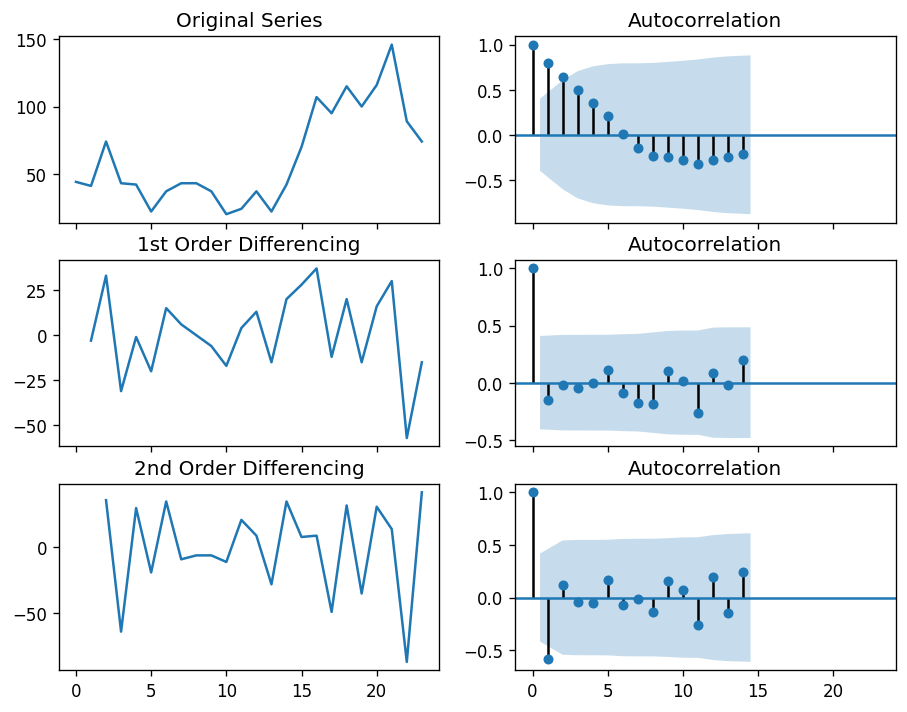

In [101]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Import data

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.AmountConsumed); axes[0, 0].set_title('Original Series')
plot_acf(df.AmountConsumed, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.AmountConsumed.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.AmountConsumed.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.AmountConsumed.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.AmountConsumed.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

<center> Partial Auto Correlation Function (PACF) </center>
$$Yt = \alpha0 + \alpha1 Y{t-1} + \alpha2 Y{t-2} + \alpha3 Y{t-3}$$

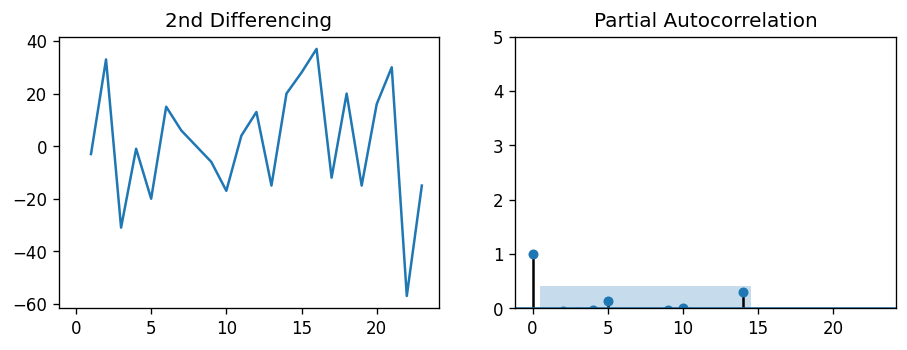

In [102]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.AmountConsumed.diff()); axes[0].set_title('2nd Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.AmountConsumed.diff().dropna(), ax=axes[1])

plt.show()

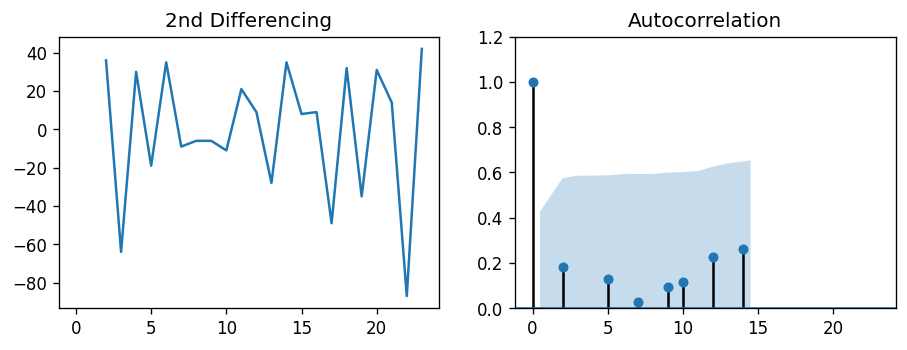

In [103]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})


fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.AmountConsumed.diff().diff()); axes[0].set_title('2nd Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.AmountConsumed.diff().diff().diff().dropna(), ax=axes[1])

plt.show()

In [104]:
#ARIMA
model = ARIMA(df.AmountConsumed, order=(1,2,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:      D2.AmountConsumed   No. Observations:                   22
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -101.363
Method:                       css-mle   S.D. of innovations             22.472
Date:                Tue, 26 May 2020   AIC                            210.726
Time:                        01:32:58   BIC                            215.090
Sample:                             2   HQIC                           211.754
                                                                              
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.0532      0.643     -0.083      0.934      -1.314       1.207
ar.L1.D2.AmountConsumed    -0.1138      0.213     -0.535      0.592      -0.531       0.303


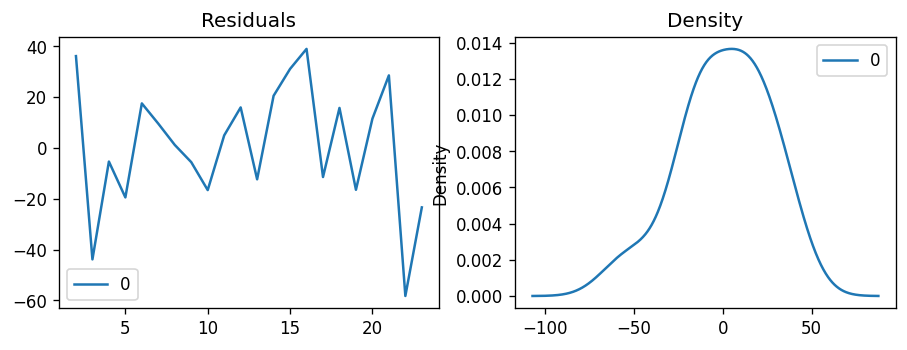

In [105]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

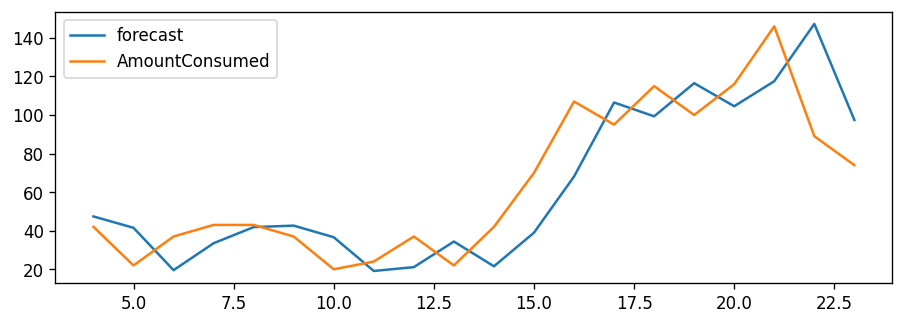

In [106]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

In [107]:
# Create Training and Test
df=df.set_index("YearMonth")
train = df

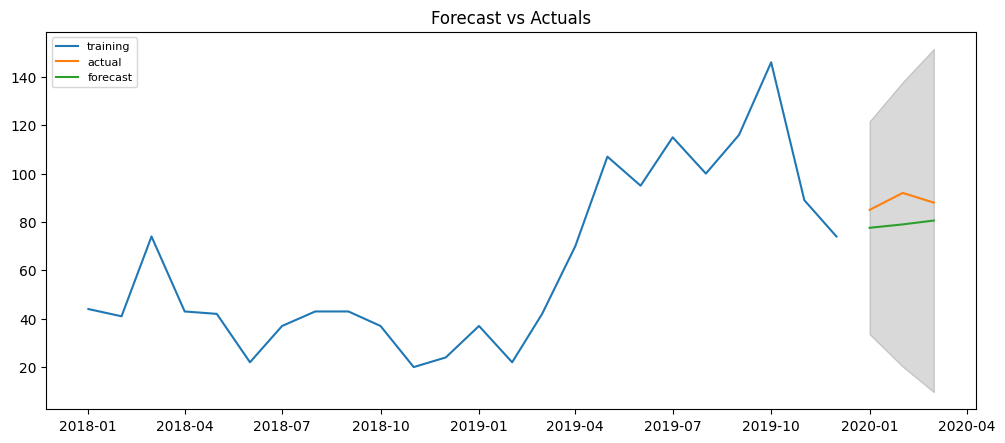

In [108]:
# Build Model

model = ARIMA(train, order=(1, 2, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(len(test), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [109]:
#Correlation
np.corrcoef(fc, test.values.reshape(len(test),))

array([[1.        , 0.39418872],
       [0.39418872, 1.        ]])

In [110]:
#MAPE
mape=np.mean(np.abs(fc - test.values.reshape(len(test),))/np.abs(test.values.reshape(len(test),)))
mape

0.10426357705042742

In [111]:
#MAE
mae=np.mean(np.abs(fc - test.values.reshape(len(test),)))
mae

9.276442429399461

In [112]:
forecast=pd.DataFrame(fc.reshape(len(test),1))
forecast=forecast.rename(columns={0:"Forecast"})
forecast["YearMonth"]=(["2020-01-01", "2020-02-01", "2020-03-01"])
forecast=forecast.set_index("YearMonth")
forecast

,Forecast
YearMonth,
2020-01-01,77.584333
2020-02-01,78.994135
2020-03-01,80.592205


In [113]:
x=pd.merge(test, forecast, left_index=True, right_index=True)
bd=train.append(x)
bd["MedCode"]=code
bd.to_csv("3500322_forecast.csv")

In [114]:
d = {'MAPE': [mape], 'MAE': [mae], "AIC":[fitted.aic], "MedCode":[code]}
metrics = pd.DataFrame(data=d)
metrics

,MAPE,MAE,AIC,MedCode
0,0.104264,9.276442,210.726276,3500322


<center><h2> 3301771  

In [115]:
code=3301771

df=MonthlyCompounds[MonthlyCompounds["MedCode"]==code][["YearMonth","AmountConsumed"]].reset_index()
df=df.sort_values("YearMonth")
df=df.drop("index", axis=1).reset_index().drop("index", axis=1)


test=AmountConsumed2020[AmountConsumed2020["MedCode"]==code]
test=test[["YearMonth", "AmountConsumed"]].reset_index().drop("index", axis=1).set_index("YearMonth")

In [116]:
# Dicky Fuller Test
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.AmountConsumed)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.069752
p-value: 0.256850


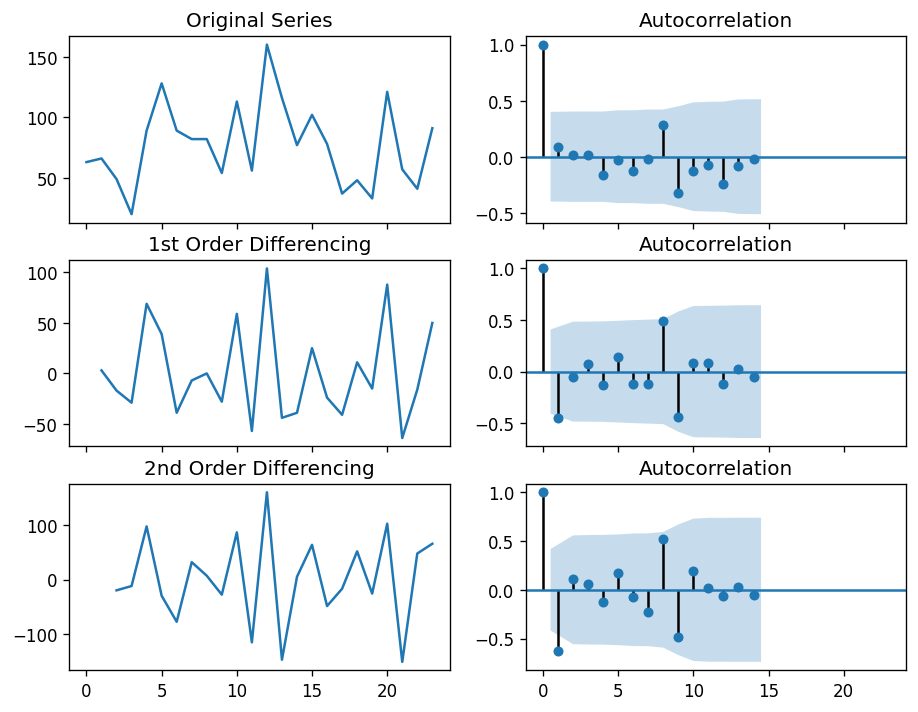

In [117]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})



# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.AmountConsumed); axes[0, 0].set_title('Original Series')
plot_acf(df.AmountConsumed, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.AmountConsumed.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.AmountConsumed.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.AmountConsumed.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.AmountConsumed.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

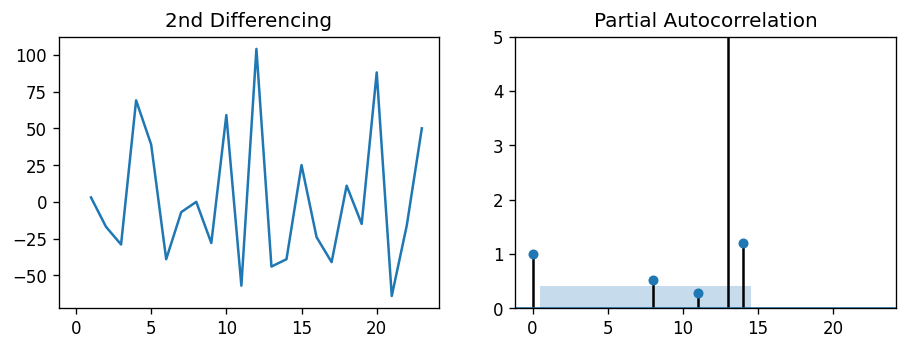

In [118]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.AmountConsumed.diff()); axes[0].set_title('2nd Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.AmountConsumed.diff().dropna(), ax=axes[1])

plt.show()

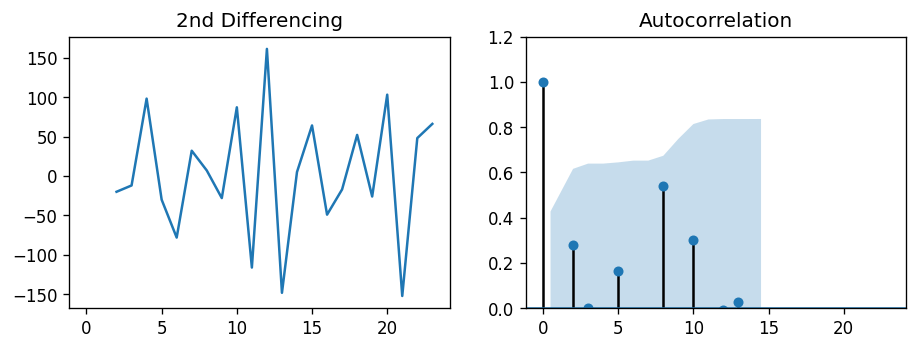

In [119]:

plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.AmountConsumed.diff().diff()); axes[0].set_title('2nd Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.AmountConsumed.diff().diff().diff().dropna(), ax=axes[1])

plt.show()

In [120]:
#ARIMA
model = ARIMA(df.AmountConsumed, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:       D.AmountConsumed   No. Observations:                   23
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -115.230
Method:                       css-mle   S.D. of innovations             34.034
Date:                Tue, 26 May 2020   AIC                            238.461
Time:                        01:33:02   BIC                            243.003
Sample:                             1   HQIC                           239.603
                                                                              
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.0113      1.135     -0.010      0.992      -2.235       2.212
ar.L1.D.AmountConsumed     0.1291      0.211      0.612      0.541      -0.285       0.543
ma.L

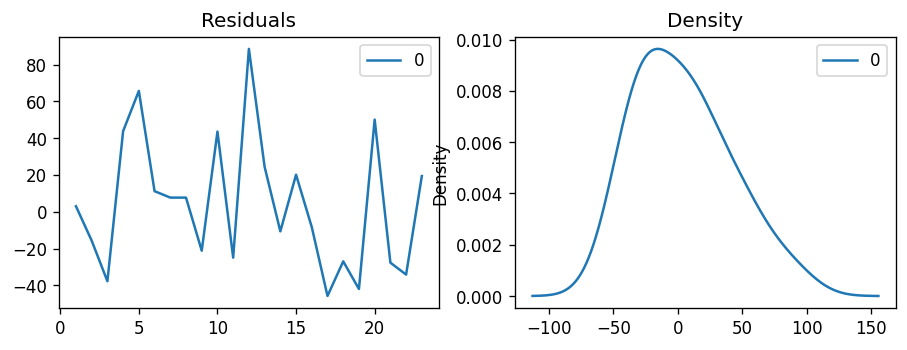

In [121]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

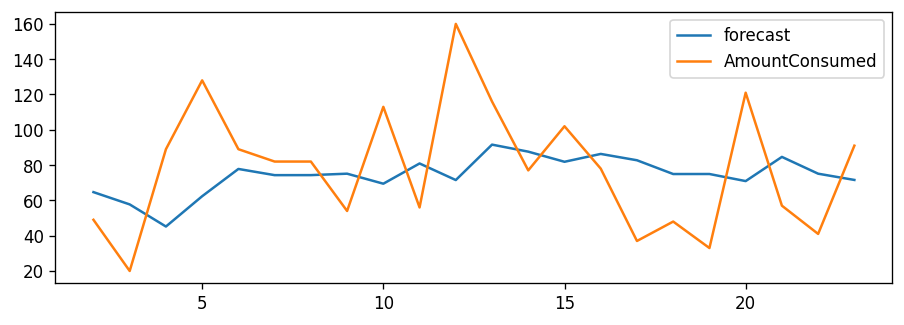

In [122]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

In [123]:
# Create Training and Test
df=df.set_index("YearMonth")
train = df

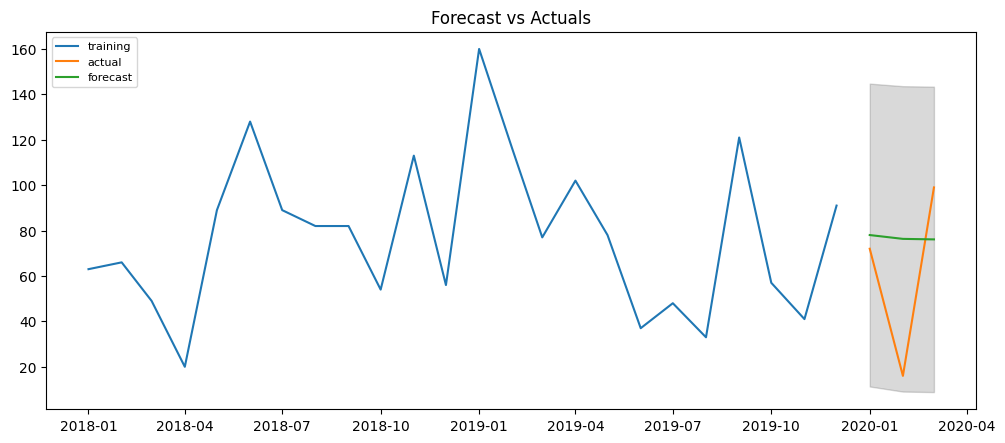

In [124]:
# Build Model

model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(len(test), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [125]:
#Correlation
np.corrcoef(fc, test.values.reshape(len(test),))

array([[1.        , 0.08987129],
       [0.08987129, 1.        ]])

In [126]:
#MAPE
mape=np.mean(np.abs(fc - test.values.reshape(len(test),))/np.abs(test.values.reshape(len(test),)))
mape

1.3620905391211842

In [127]:
#MAE
mae=np.mean(np.abs(fc - test.values.reshape(len(test),)))
mae

29.75155737251701

In [128]:
forecast=pd.DataFrame(fc.reshape(len(test),1))
forecast=forecast.rename(columns={0:"Forecast"})
forecast["YearMonth"]=(["2020-01-01", "2020-02-01", "2020-03-01"])
forecast=forecast.set_index("YearMonth")
forecast

,Forecast
YearMonth,
2020-01-01,78.027266
2020-02-01,76.342360
2020-03-01,76.114954


In [129]:
x=pd.merge(test, forecast, left_index=True, right_index=True)
bd=train.append(x)
bd["MedCode"]=code
bd.to_csv("3301771_forecast.csv")

In [130]:
d = {'MAPE': [mape], 'MAE': [mae], "AIC":[fitted.aic], "MedCode":[code]}
metrics = pd.DataFrame(data=d)
metrics

,MAPE,MAE,AIC,MedCode
0,1.362091,29.751557,238.460978,3301771


<center><h2> 3300663

In [131]:
code=3300663

df=MonthlyCompounds[MonthlyCompounds["MedCode"]==code][["YearMonth","AmountConsumed"]].reset_index()
df=df.sort_values("YearMonth")
df=df.drop("index", axis=1).reset_index().drop("index", axis=1)


test=AmountConsumed2020[AmountConsumed2020["MedCode"]==code]
test=test[["YearMonth", "AmountConsumed"]].reset_index().drop("index", axis=1).set_index("YearMonth")
test


,AmountConsumed
YearMonth,
2020-01-01,35
2020-02-01,5
2020-03-01,12


In [132]:
# Dicky Fuller Test
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.AmountConsumed)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.049349
p-value: 0.265363


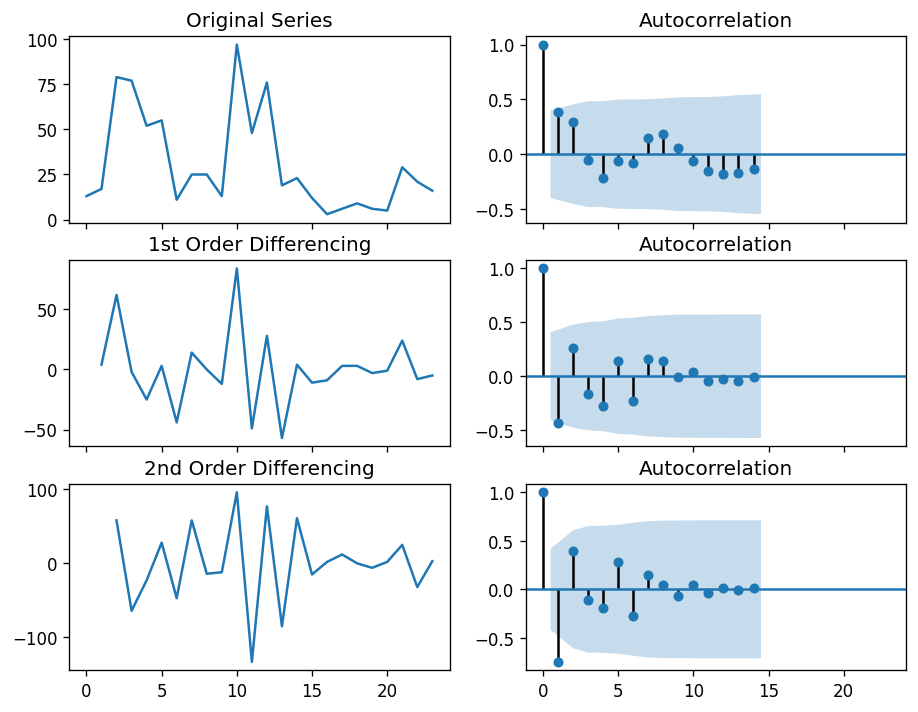

In [133]:

plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.AmountConsumed); axes[0, 0].set_title('Original Series')
plot_acf(df.AmountConsumed, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.AmountConsumed.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.AmountConsumed.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.AmountConsumed.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.AmountConsumed.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

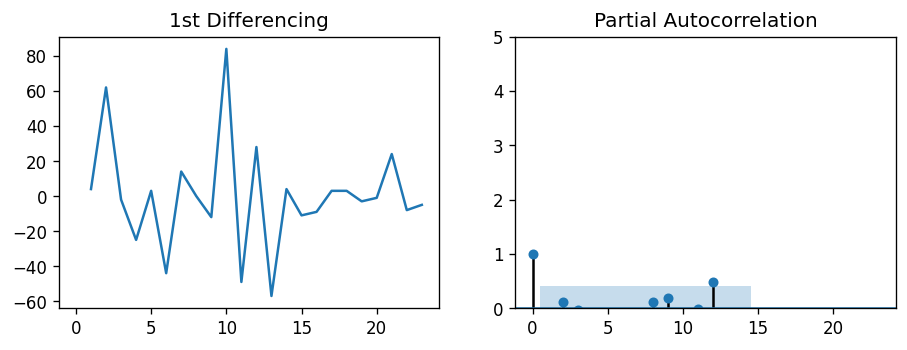

In [134]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.AmountConsumed.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.AmountConsumed.diff().dropna(), ax=axes[1])

plt.show()

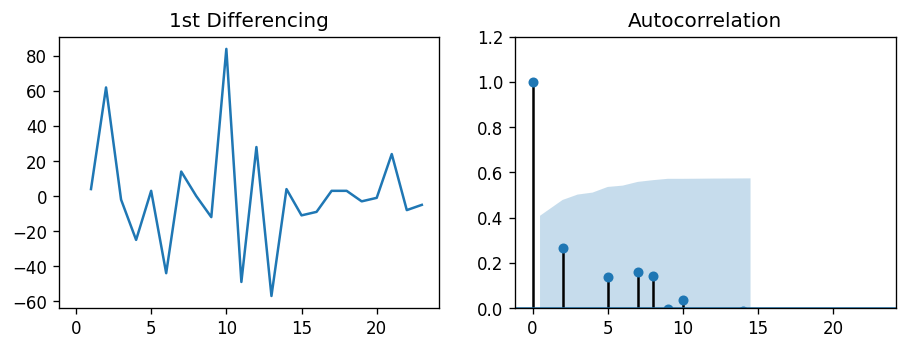

In [135]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

# Import data

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.AmountConsumed.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.AmountConsumed.diff().dropna(), ax=axes[1])

plt.show()

In [136]:
#ARIMA
model = ARIMA(df.AmountConsumed, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:       D.AmountConsumed   No. Observations:                   23
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -108.779
Method:                       css-mle   S.D. of innovations             27.285
Date:                Tue, 26 May 2020   AIC                            225.559
Time:                        01:33:05   BIC                            230.101
Sample:                             1   HQIC                           226.701
                                                                              
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.2329      4.318      0.054      0.957      -8.229       8.695
ar.L1.D.AmountConsumed    -0.5471      0.318     -1.723      0.085      -1.170       0.075
ma.L

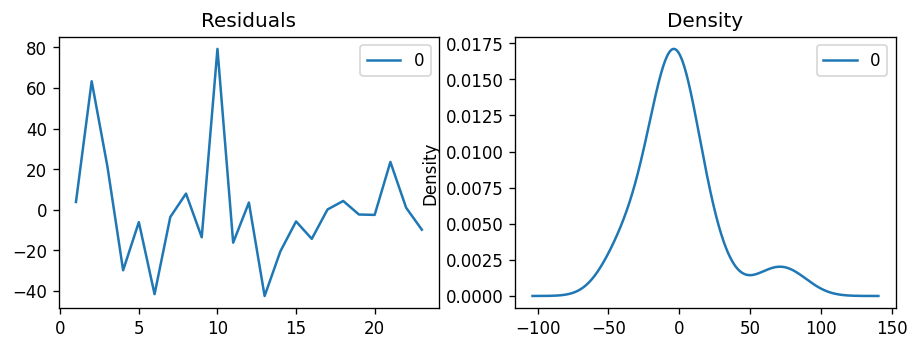

In [137]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

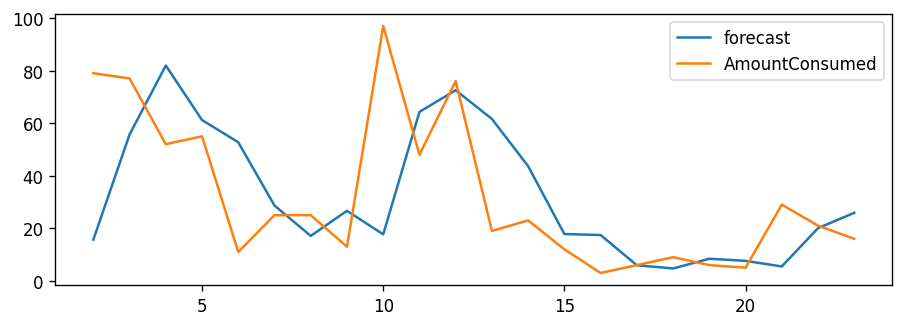

In [138]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

In [139]:
# Create Training and Test
df=df.set_index("YearMonth")
train = df

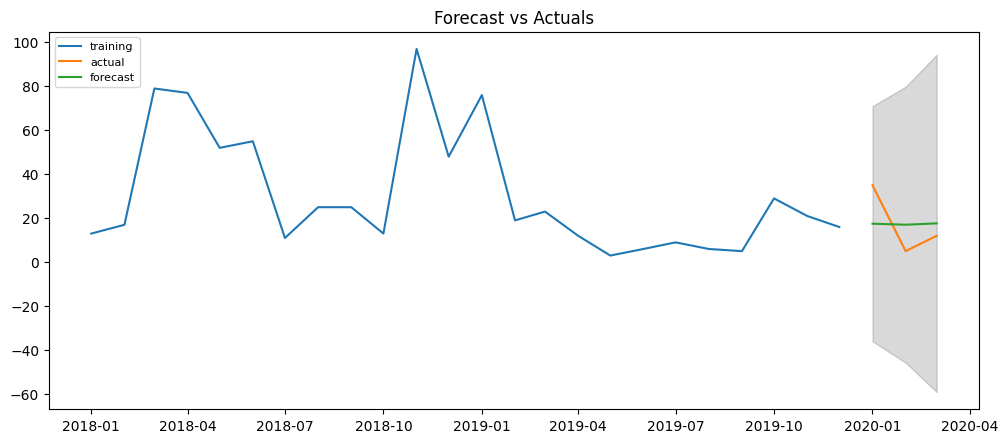

In [140]:
# Build Model

model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(len(test), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [141]:
#Correlation
np.corrcoef(fc, test.values.reshape(len(test),))

array([[1.        , 0.48050439],
       [0.48050439, 1.        ]])

In [142]:
#MAPE
mape=np.mean(np.abs(fc - test.values.reshape(len(test),))/np.abs(test.values.reshape(len(test),)))
mae=np.mean(np.abs(fc - test.values.reshape(len(test),)))
forecast=pd.DataFrame(fc.reshape(len(test),1))
forecast=forecast.rename(columns={0:"Forecast"})
forecast["YearMonth"]=(["2020-01-01", "2020-02-01", "2020-03-01"])
forecast=forecast.set_index("YearMonth")
forecast

,Forecast
YearMonth,
2020-01-01,17.487936
2020-02-01,17.034169
2020-03-01,17.642763


In [143]:
x=pd.merge(test, forecast, left_index=True, right_index=True)
bd=train.append(x)
bd["MedCode"]=code
bd.to_csv("3300663_forecast.csv")

In [144]:
d = {'MAPE': [mape], 'MAE': [mae], "AIC":[fitted.aic], "MedCode":[code]}
metrics = pd.DataFrame(data=d)
metrics

,MAPE,MAE,AIC,MedCode
0,1.125803,11.729665,225.558641,3300663
